* [Yelp, Not Kaggle Data Source](https://www.yelp.com/dataset/download)
* [Data Dictionary](https://www.yelp.com/dataset/documentation/main)

* [x] Get data into csv to work in pandas
* [x] Perform sentiment classification with Hugging Face model (2024 SOTA)
* [ ] Extract from text key words that resulted in sentiment class (entity-based sentiment analysis)
* [x] topic modeling
* [ ] other advanced analytics for reviews using LLM/HuggingFace
* [ ] compare competition side-by-side (Japanese restaurants)
* [ ] get criteria for ranking/qualities in restaurant based on aggregation of common words through clustering

In [1]:
!pip install duckdb jupysql -q transformers torch bertopic pyabsa --quiet  
!python -m spacy download en_core_web_md --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kaggle-environments 1.14.3 requires scipy>=1.11.2, but you have scipy 1.10.1 which is incompatible.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
momepy 0.7.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
ydata-profiling 4.6.4 requires numpy<1.26,>=1.16.0, but you have numpy 1.26.4 which is incompatible.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [2]:
# Computation Status Bar
from tqdm.notebook import tqdm
tqdm.pandas()

# Data Processing
import json
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)

import duckdb
%load_ext sql
conn = duckdb.connect()
%sql conn --alias duckdb

import re
from collections import Counter

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# NLP Processing and Model Inference
from nltk.corpus import stopwords
import torch
import nltk
from transformers import pipeline, AutoTokenizer
## Generate different embeddings
import tensorflow
import tensorflow_hub as hub

# Sentiment Analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer 

# Topic Modeling
import spacy
nlp = spacy.load('en_core_web_md')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from gensim import corpora
from gensim.models.ldamodel import LdaModel

from bertopic import BERTopic
from sentence_transformers import SentenceTransformer, util
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import MaximalMarginalRelevance

# Aspect Based Sentiment Analysis


Deploy Dash apps for free on Ploomber Cloud! Learn more: https://ploomber.io/s/signup


2024-06-11 01:49:42.531574: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-11 01:49:42.531699: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-11 01:49:42.725269: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [3]:
dfr = pd.read_csv('/kaggle/input/yelp-revised/yelp_biz_rev.csv')
dfr.head()

/tmp/ipykernel_18/3121522079.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  dfr = pd.read_csv('/kaggle/input/yelp-revised/yelp_biz_rev.csv')


,Unnamed: 0,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,attributes,categories,review_id,user_id,review_stars,text,date
0,0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80.0,"{'key': ['RestaurantsDelivery', 'OutdoorSeating', 'BusinessAcceptsCreditCards', 'BusinessParking', 'BikeParking', 'RestaurantsPriceRange2', 'RestaurantsTakeOut', 'ByAppointmentOnly', 'WiFi', 'Alcohol', 'Caters'], 'value': ['False', 'False', 'False', ""{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}"", 'True', '1', 'True', 'False', ""u'free'"", ""u'none'"", 'True']}","Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries",BXQcBN0iAi1lAUxibGLFzA,6_SpY41LIHZuIaiDs5FMKA,4.0,"This is nice little Chinese bakery in the heart of Philadelphia's Chinatown! The female cashier was very friendly (flirtatious!) and the pastries shown in nicely adorned display cases. I stopped by early one evening had a sesame ball, which was filled with bean paste. The glutinous rice of the ball was nicely flavored, similar to Bai Tang Gao. Definitely as place worth stopping at if you are in the area.",2014-05-26 01:09:53
1,1,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80.0,"{'key': ['RestaurantsDelivery', 'OutdoorSeating', 'BusinessAcceptsCreditCards', 'BusinessParking', 'BikeParking', 'RestaurantsPriceRange2', 'RestaurantsTakeOut', 'ByAppointmentOnly', 'WiFi', 'Alcohol', 'Caters'], 'value': ['False', 'False', 'False', ""{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}"", 'True', '1', 'True', 'False', ""u'free'"", ""u'none'"", 'True']}","Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries",uduvUCvi9w3T2bSGivCfXg,tCXElwhzekJEH6QJe3xs7Q,4.0,"This is the bakery I usually go to in Chinatown. They have a decent variety of buns and pastries. Red bean-filled buns, mung bean-filled buns, coconut stuff, egg tarts etc. If you buy a dozen, they will give you two more for free. The prices are standard for a Chinese bakery, with most things at approximately $1. The service has always been good. They do serve coffee and tea. There are a couple of tables inside, with usually the expected group of older Chinese guys chillin' in the corner table debating about something. Great place to stock up on the buns, which I usually do before leaving town.",2013-10-05 15:19:06
2,2,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80.0,"{'key': ['RestaurantsDelivery', 'OutdoorSeating', 'BusinessAcceptsCreditCards', 'BusinessParking', 'BikeParking', 'RestaurantsPriceRange2', 'RestaurantsTakeOut', 'ByAppointmentOnly', 'WiFi', 'Alcohol', 'Caters'], 'value': ['False', 'False', 'False', ""{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}"", 'True', '1', 'True', 'False', ""u'free'"", ""u'none'"", 'True']}","Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries",a0vwPOqDXXZuJkbBW2356g,WqfKtI-aGMmvbA9pPUxNQQ,5.0,"A delightful find in Chinatown! Very clean, and very kind service. Everyone always seems happy in here, and their treats are absolutely delicious. You can also get a ton of sweet treats without any judgement! They're my favorite.",2013-10-25 01:34:57
3,3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80.0,"{'key': ['RestaurantsDelivery', 'OutdoorSeating', 'BusinessAcceptsCreditCards', 'BusinessParking', 'BikeParking', 'RestaurantsPriceRange2', 'RestaurantsTakeOut', 'ByAppointmentOnly', 'WiFi', 'Alcohol', 'Caters'], 'value': ['False', 'False', 'False', ""{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}"", 'True', '1', 'True', 'False', ""u'free'"", ""u'none'"", 'True']}","Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries",MKNp_CdR2k2202-c8GN5Dw,3-1va0IQfK-9tUMzfHWfTA,5.0,I ordered a graduation cake for my niece and 

In [4]:
# dfr['categories'].value_counts()[:20]                                                                           

In [5]:
# Need to clean up category data

query = """
select business_id
, name
, address
, city
, state
, postal_code
, latitude
, longitude
, stars
, review_count
, attributes
, case when categories = 'Mexican, Restaurants' then 'Restaurants, Mexican'
when categories = 'Pizza, Restaurants' then 'Restaurants, Pizza'
when categories = 'Chinese, Restaurants' then 'Restaurants, Chinese'
when categories = 'Italian, Restaurants' then 'Restaurants, Italian'
when categories = 'Thai, Restaurants' then 'Restaurants, Thai'
when categories = 'Seafood, Restaurants' then 'Restaurants, Seafood'
when categories = 'American (New), Restaurants' then 'Restaurants, American (New)'
when categories = 'Thai, Restaurants' then 'Restaurants, Thai'
when categories = 'Seafood, Restaurants' then 'Restaurants, Seafood'
when categories = 'Vietnamese, Restaurants' then 'Restaurants, Vietnamese'
when categories = 'Cajun/Creole, Restaurants' then 'Restaurants, Cajun/Creole'
else categories
end as categories
, review_id
, user_id
, review_stars
, text
, date
from dfr
"""

dfr = duckdb.query(query).df()
dfr['categories'].value_counts()[:20]

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

categories
Restaurants, Mexican                                                                                     88958
Restaurants, Pizza                                                                                       49803
Restaurants, Chinese                                                                                     40040
Restaurants, Italian                                                                                     39086
Restaurants, Thai                                                                                        23803
Restaurants, American (New)                                                                              22206
Restaurants, Seafood                                                                                     20771
Restaurants, Vietnamese                                                                                  15508
Restaurants, Cajun/Creole                                                                            

In [6]:
# dfr['categories'].value_counts()[:20]

In [7]:
query = """
select review_id
, review_stars
, text
from dfr
"""

df_sent2 = duckdb.query(query).df()
df_sent2

,review_id,review_stars,text
0,BXQcBN0iAi1lAUxibGLFzA,4.0,"This is nice little Chinese bakery in the heart of Philadelphia's Chinatown! The female cashier was very friendly (flirtatious!) and the pastries shown in nicely adorned display cases. I stopped by early one evening had a sesame ball, which was filled with bean paste. The glutinous rice of the ball was nicely flavored, similar to Bai Tang Gao. Definitely as place worth stopping at if you are in the area."
1,uduvUCvi9w3T2bSGivCfXg,4.0,"This is the bakery I usually go to in Chinatown. They have a decent variety of buns and pastries. Red bean-filled buns, mung bean-filled buns, coconut stuff, egg tarts etc. If you buy a dozen, they will give you two more for free. The prices are standard for a Chinese bakery, with most things at approximately $1. The service has always been good. They do serve coffee and tea. There are a couple of tables inside, with usually the expected group of older Chinese guys chillin' in the corner table debating about something. Great place to stock up on the buns, which I usually do before leaving town."
2,a0vwPOqDXXZuJkbBW2356g,5.0,"A delightful find in Chinatown! Very clean, and very kind service. Everyone always seems happy in here, and their treats are absolutely delicious. You can also get a ton of sweet treats without any judgement! They're my favorite."
3,MKNp_CdR2k2202-c8GN5Dw,5.0,I ordered a graduation cake for my niece and it came out absolutely perfect. Will come again for future events! Staff was nice also and the cake was really good.
4,D1GisLDPe84Rrk_R4X2brQ,4.0,"HK-STYLE MILK TEA: FOUR STARS\n\nNot quite sure why there are two Saint Honore Pastries business listings on Yelp, but I have been checking in to this one.\n\nBoyfriend and I go by it all the time while in Chinatown, but it never crossed our mind to try it. I think we might have tried it once a year or two ago, but it wasn't memorable. I decided to try the HK-style milk tea not too long ago and was hooked. I think I went here almost every day one week to get the milk tea, only to realize that I should REALLY watch my sugar intake...it's sooo good! \n\nI personally don't think it's better than Zhong Gang's HK-style milk tea because they have their off days when a certain lady makes them (not enough ice, too much ice, etc.).\n\nOn a side note: I wanted to try the crispy roast pork bun, but accidentally said the wrong name in Chinese and got the roast pork bun. It was decent enough, although I will get to trying the crispy roast pork bun soon! \n\nI will be back~"
...,...,...,...
3773767,Kt3gFeW1rhZz7RuiV-6Tcw,5.0,"This is my favorite food truck! I only wish I lived closer to Philly so that I could eat here more often. The prices are affordable, the portions are generous, the staff is friendly, and the food is AMAZING. \n\nThe last time I went to the Plum Pit, I ordered a jerk chicken sandwich to split with a friend. Learn from our mistake--order your own sandwich, and if you can't finish it, save half for later. We ended up going back for another sandwich (the one with chicken tenders, mac & cheese, and bacon--I can't remember the name) anyway. We also got two orders of bread pudding to bring home, which, though pretty good cold, is ever better when you heat it up in the oven for 10-15 minutes."
3773768,ruy3Ycey_gGbwkE_3TX1Fg,5.0,"This food truck was stupid. Stupidly delicious. \n\nShould be a 4.5 because they were a little slow compared to other trucks, but once the food showed up, totally ON POINT.\n\nWe had the bacon Mac and cheese with the French fry bowl, topped with jerk chicken. I could not get enough of the jerk chicken. And the bacon Mac and cheese was super creamy ( again 4.5 we saw a big can of nacho cheese instead of good cheese "" . \n\nWould definitely eat here again if they were at the Stables."
3773769,C_l8NTpvNOEUorEmEOusaA,5.0,Bubba never disappoints i go to his fb page and hunt him down and now i have my friends and family stalking him too. One of the main r

In [8]:
# reduce file size by getting sample
#sample 500,000 to use less RAM
sample = df_sent2.sample(n=500000)
len(sample)

500000

In [9]:
# sample.head(1)

# Text Pre-Processing

In [10]:
# text column needs to be changed to string...
sample['text'] = sample['text'].apply(str)

In [11]:
# Get code to clean text: remove HTML tags
def cleanhtml(x): 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', x) 
    return cleantext.replace('\n\n', ' ').replace('\n', '')
    
sample['clean_text'] = sample.apply(lambda row: cleanhtml(row['text']), axis=1)

# Examine sample of dirty comments to see if translation went through
sample

,review_id,review_stars,text,clean_text
50336,eddF9GCGJfYjyc2X5jvYcw,5.0,"A true 5 star, can't recommend enough. Amazing creative donuts, awesome biscuits, great service, would tell anyone it is a must visit!","A true 5 star, can't recommend enough. Amazing creative donuts, awesome biscuits, great service, would tell anyone it is a must visit!"
195803,4n6rvoWxcWS53MUfOcTclA,5.0,I love fried crawfish tails and cocktail sauce here! I have to refrain from eating two orders by myself. Ice cold beer makes for a great afternoon.,I love fried crawfish tails and cocktail sauce here! I have to refrain from eating two orders by myself. Ice cold beer makes for a great afternoon.
2189570,MUpsKI7EFwbIfCblAScDGA,4.0,Loved this out of the way gem. Mussels & Lamb Tagine were excellent. The owner served us with such a generous spirit. Highly recommend.,Loved this out of the way gem. Mussels & Lamb Tagine were excellent. The owner served us with such a generous spirit. Highly recommend.
219042,ffe4Tyo1LhpGjLws7IV8ig,3.0,"The special cornmeal Santa fe pancakes were amazing. Think cornbread with Chilies, onion and bacon. Delicious! My group of friends got an order of those and hashbrowns for the table to share. I got a t and j sandwich- essentially a grilled cheese with turkey. I tried a sandwich that came with a pretzel roll which was pretty good. \n\nThe special Santa fe pancakes were a standout, the sandwiches were average.","The special cornmeal Santa fe pancakes were amazing. Think cornbread with Chilies, onion and bacon. Delicious! My group of friends got an order of those and hashbrowns for the table to share. I got a t and j sandwich- essentially a grilled cheese with turkey. I tried a sandwich that came with a pretzel roll which was pretty good. The special Santa fe pancakes were a standout, the sandwiches were average."
3564732,0HnAy4hNnXCbRSp4kIts9A,1.0,"I went to this Burger King at 6:15 am- 11/1/19. The manager (I think her name is Christine) took my order in drive thru. When I got to the window to pay, she said she didn't have my order and she can't take it from the window. She wanted me to get back in line. I asked for her manger's number and she took a torn receipt from the counter, gave it to me, said bye black bitch and closed the window. I will never go to Burger King again. #Racist","I went to this Burger King at 6:15 am- 11/1/19. The manager (I think her name is Christine) took my order in drive thru. When I got to the window to pay, she said she didn't have my order and she can't take it from the window. She wanted me to get back in line. I asked for her manger's number and she took a torn receipt from the counter, gave it to me, said bye black bitch and closed the window. I will never go to Burger King again. #Racist"
...,...,...,...,...
2446734,To5YjhDcfdNonjvRrKfo5Q,5.0,"My boyfriend and I try to come here for breakfast/lunch/brunch as much as we can because we absolutely love it. It's clean, it's friendly, it's cute and cozy, and it's not pretentious.\n\nIt's mostly a neighborhood-y joint, which, to me, translates to awesome food. Unfortunately, its strong sense of community means it fills up fast for breakfast/brunch on the weekends. Luckily, we've found a way around this problem: since the Fitzwater Cafe is frequented by mostly working class locals, we've noticed that if you come for breakfast/lunch during the week (which they offer and I greatly appreciate), you will be seated immediately!\n\nOne of my favorites is the Prosciutto sandwich. It comes with the perfect ratio of pesto, greens, tomato, and meat on a satisfyingly crispy Sarcone's roll (which I am always a sucker for). I also add some fresh mozzarella to put it over the top. You get your choice of a side salad or homefries (both of which are worth trying). I always pretend that I'm only going to eat half of the sandwich and save the rest for later, but I always give in and devour the entire thing.","My boyfriend and I try to come here for breakfast/lunch/brun

In [12]:
# normalize text by lowering it all
sample['clean_text'] = sample['clean_text'].str.lower()

In [13]:
%%time
# Due to transformer error:
# If you are running a transformer model with HuggingFace, there is a chance that one of the input sentences is longer than 512 tokens. Either truncate or split your sentences. I suspect the shorter sentences are padded to 512 tokens.

#1. get token length/total words with max: 500 total words as max length since tokenizer can add suffixes as a token
#2. eliminate tokens lengths greater than max/summarize text using chatgpt?

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
# sentence = "Sentence to check whether it exceeds 512 tokens"

# tokenized_sentence = tokenizer.tokenize(sentence)

# print(len(sentence.split()))  # here is the default length of the sentence
# print(len(tokenized_sentence)) # here is the tokenized length

## Example applied to df

sample['num_tokens_tok'] = sample.apply(lambda row: len(tokenizer.tokenize(row.clean_text)), axis = 1)
sample.head()

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (628 > 512). Running this sequence through the model will result in indexing errors


CPU times: user 5min 51s, sys: 20.9 ms, total: 5min 51s
Wall time: 5min 53s


,review_id,review_stars,text,clean_text,num_tokens_tok
50336,eddF9GCGJfYjyc2X5jvYcw,5.0,"A true 5 star, can't recommend enough. Amazing creative donuts, awesome biscuits, great service, would tell anyone it is a must visit!","a true 5 star, can't recommend enough. amazing creative donuts, awesome biscuits, great service, would tell anyone it is a must visit!",31
195803,4n6rvoWxcWS53MUfOcTclA,5.0,I love fried crawfish tails and cocktail sauce here! I have to refrain from eating two orders by myself. Ice cold beer makes for a great afternoon.,i love fried crawfish tails and cocktail sauce here! i have to refrain from eating two orders by myself. ice cold beer makes for a great afternoon.,32
2189570,MUpsKI7EFwbIfCblAScDGA,4.0,Loved this out of the way gem. Mussels & Lamb Tagine were excellent. The owner served us with such a generous spirit. Highly recommend.,loved this out of the way gem. mussels & lamb tagine were excellent. the owner served us with such a generous spirit. highly recommend.,31
219042,ffe4Tyo1LhpGjLws7IV8ig,3.0,"The special cornmeal Santa fe pancakes were amazing. Think cornbread with Chilies, onion and bacon. Delicious! My group of friends got an order of those and hashbrowns for the table to share. I got a t and j sandwich- essentially a grilled cheese with turkey. I tried a sandwich that came with a pretzel roll which was pretty good. \n\nThe special Santa fe pancakes were a standout, the sandwiches were average.","the special cornmeal santa fe pancakes were amazing. think cornbread with chilies, onion and bacon. delicious! my group of friends got an order of those and hashbrowns for the table to share. i got a t and j sandwich- essentially a grilled cheese with turkey. i tried a sandwich that came with a pretzel roll which was pretty good. the special santa fe pancakes were a standout, the sandwiches were average.",92
3564732,0HnAy4hNnXCbRSp4kIts9A,1.0,"I went to this Burger King at 6:15 am- 11/1/19. The manager (I think her name is Christine) took my order in drive thru. When I got to the window to pay, she said she didn't have my order and she can't take it from the window. She wanted me to get back in line. I asked for her manger's number and she took a torn receipt from the counter, gave it to me, said bye black bitch and closed the window. I will never go to Burger King again. #Racist","i went to this burger king at 6:15 am- 11/1/19. the manager (i think her name is christine) took my order in drive thru. when i got to the window to pay, she said she didn't have my order and she can't take it from the window. she wanted me to get back in line. i asked for her manger's number and she took a torn receipt from the counter, gave it to me, said bye black bitch and closed the window. i will never go to burger king again. #racist",117


In [14]:
# get rid of rows that are <450 words in length since this tokenizer is approx of tokenizer used for sentiment model
query = """
select *
from sample
where num_tokens_tok < 450
"""

sample_short_rev = duckdb.query(query).df()
sample_short_rev.head()

,review_id,review_stars,text,clean_text,num_tokens_tok
0,eddF9GCGJfYjyc2X5jvYcw,5.0,"A true 5 star, can't recommend enough. Amazing creative donuts, awesome biscuits, great service, would tell anyone it is a must visit!","a true 5 star, can't recommend enough. amazing creative donuts, awesome biscuits, great service, would tell anyone it is a must visit!",31
1,4n6rvoWxcWS53MUfOcTclA,5.0,I love fried crawfish tails and cocktail sauce here! I have to refrain from eating two orders by myself. Ice cold beer makes for a great afternoon.,i love fried crawfish tails and cocktail sauce here! i have to refrain from eating two orders by myself. ice cold beer makes for a great afternoon.,32
2,MUpsKI7EFwbIfCblAScDGA,4.0,Loved this out of the way gem. Mussels & Lamb Tagine were excellent. The owner served us with such a generous spirit. Highly recommend.,loved this out of the way gem. mussels & lamb tagine were excellent. the owner served us with such a generous spirit. highly recommend.,31
3,ffe4Tyo1LhpGjLws7IV8ig,3.0,"The special cornmeal Santa fe pancakes were amazing. Think cornbread with Chilies, onion and bacon. Delicious! My group of friends got an order of those and hashbrowns for the table to share. I got a t and j sandwich- essentially a grilled cheese with turkey. I tried a sandwich that came with a pretzel roll which was pretty good. \n\nThe special Santa fe pancakes were a standout, the sandwiches were average.","the special cornmeal santa fe pancakes were amazing. think cornbread with chilies, onion and bacon. delicious! my group of friends got an order of those and hashbrowns for the table to share. i got a t and j sandwich- essentially a grilled cheese with turkey. i tried a sandwich that came with a pretzel roll which was pretty good. the special santa fe pancakes were a standout, the sandwiches were average.",92
4,0HnAy4hNnXCbRSp4kIts9A,1.0,"I went to this Burger King at 6:15 am- 11/1/19. The manager (I think her name is Christine) took my order in drive thru. When I got to the window to pay, she said she didn't have my order and she can't take it from the window. She wanted me to get back in line. I asked for her manger's number and she took a torn receipt from the counter, gave it to me, said bye black bitch and closed the window. I will never go to Burger King again. #Racist","i went to this burger king at 6:15 am- 11/1/19. the manager (i think her name is christine) took my order in drive thru. when i got to the window to pay, she said she didn't have my order and she can't take it from the window. she wanted me to get back in line. i asked for her manger's number and she took a torn receipt from the counter, gave it to me, said bye black bitch and closed the window. i will never go to burger king again. #racist",117


In [15]:
#Check max number tokens
# query = """
# select max(num_tokens_tok) as max_tokens
# from sample_short_rev
# """

# duckdb.query(query).df()

In [16]:
# remaining of sample after token length filter
# len(sample_short_rev)

# Sentiment Classification

In [17]:
# using Hugging Face sentiment classifier trained on Yelp restaurant reviews

# Set up the inference pipeline using a model from the 🤗 Hub

sentiment_analysis = pipeline(model="mrcaelumn/yelp_restaurant_review_sentiment_analysis")

config.json:   0%|          | 0.00/769 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/315 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [18]:
test = sample_short_rev.sample(n=5000)

In [19]:
%%time

test = (
test.assign(sentiment = lambda x: x['clean_text'].apply(lambda s: sentiment_analysis(s)))
    .assign(
         label = lambda x: x['sentiment'].apply(lambda s: (s[0]['label'])),
         score = lambda x: x['sentiment'].apply(lambda s: (s[0]['score']))
    )
)

test.head()

CPU times: user 19min 30s, sys: 2.08 s, total: 19min 32s
Wall time: 9min 46s


,review_id,review_stars,text,clean_text,num_tokens_tok,sentiment,label,score
52334,o_vkIvGpwCJpjXygKSCD_Q,4.0,The food was phenomenal but their estimated time of delivery was WAY off and they forgot utensils.,the food was phenomenal but their estimated time of delivery was way off and they forgot utensils.,21,"[{'label': 'LABEL_1', 'score': 0.7558445930480957}]",LABEL_1,0.755845
148738,2SZGe-LU9MvnYrJL0nVM9A,2.0,A horses salt lick is less salty than the wings here... Also the service isn't that great had to wait over 20 minutes for a beer and it was not even close to busy.,a horses salt lick is less salty than the wings here... also the service isn't that great had to wait over 20 minutes for a beer and it was not even close to busy.,40,"[{'label': 'LABEL_1', 'score': 0.7382357716560364}]",LABEL_1,0.738236
100120,NEn4g9sr_a-CUCZ_4qsjog,4.0,I went here for dinner and had the halibut fish special with squash. It was cooked perfectly and tasted really good. Their Tom Collins cocktail w/ Hendricks was good as well.\n\nI also like coming here on Friday nights for their wine tastings on the patio when it's cooler outside.,i went here for dinner and had the halibut fish special with squash. it was cooked perfectly and tasted really good. their tom collins cocktail w/ hendricks was good as well. i also like coming here on friday nights for their wine tastings on the patio when it's cooler outside.,60,"[{'label': 'LABEL_2', 'score': 0.9942439198493958}]",LABEL_2,0.994244
62066,4pcSJtYHSfVmbJ7rulDRlQ,4.0,"Imagine my surprise after having now lived on the West Coast for 10+ years when I came home this Christmas and found one of the best cheese steaks I've had just minutes from my home growing up. The Kaiser bun threw me off a little as I've only had traditional cheese steaks growing up but it was amazing. Great taste, just the right amount of gooey, melting, messiness and some unexpected sides to top. Also very friendly and polite staff. Now I have a another new reason to look forward to coming home for the Holidays! Keep up the good work.","imagine my surprise after having now lived on the west coast for 10+ years when i came home this christmas and found one of the best cheese steaks i've had just minutes from my home growing up. the kaiser bun threw me off a little as i've only had traditional cheese steaks growing up but it was amazing. great taste, just the right amount of gooey, melting, messiness and some unexpected sides to top. also very friendly and polite staff. now i have a another new reason to look forward to coming home for the holidays! keep up the good work.",119,"[{'label': 'LABEL_2', 'score': 0.9973598122596741}]",LABEL_2,0.997360
148471,-bKCo-XTajV6a7mzO9qgEw,1.0,Once again either they miss something in my order or come out late. The two minute promise is a joke. They stopped the timer at 1:25 and came out over a minute later. When I mentioned to the person bringing my order and showed him the time he said I don't know anything about that. The young manager I showed her the time the timer started and I took a picture when the food came out the red response was their timer and my phone had to be off. Clearly she was not aware of how the timer looked on the phone . Will not return.,once again either they miss something in my order or come out late. the two minute promise is a joke. they stopped the timer at 1:25 and came out over a minute later. when i mentioned to the person bringing my order and showed him the time he said i don't know anything about that. the young manager i showed her the time the timer started and i took a picture when the food came out the red response was their timer and my phone had to be off. clearly she was not aware of how the timer looked on the phone . will not return.,116,"[{'label': 'LABEL_0', 'score': 0.9859086871147156}]",LABEL_0,0.985909


In [20]:
# Sentiment Label Breakdown
# test['label'].value_counts() # Mostly positive reviews

In [21]:
# LABEL_0 only

# query = """
# select clean_text
# , review_stars
# , label
# , score
# from test
# where label = 'LABEL_0'
# """

# label_0 = duckdb.query(query).df()
# label_0.head()

In [22]:
# label_0['review_stars'].value_counts() #for lowest star ratings/negative sentiment

In [23]:
# Curious about possible mislabeling, what are the reviews acually reading as. was user accurate in their star rating or sentiment model wrong?
# query = """
# select clean_text
# , review_stars
# , label
# , score
# from label_0
# where review_stars >=4
# """

# bad_labels_0 = duckdb.query(query).df()
# bad_labels_0

# labeling check (sampled 6)
1. incorrect rating from model - 5 (0,1,3,4,5)
2. incorrect star rating from user - 1 (2)

In [24]:
# bad_labels_0['score'].describe()

In [25]:
# print('Percentage of bad labels in negative sentiment class:',round(len(bad_labels_0)/len(label_0),2) *100, '%.')

In [26]:
# LABEL_1 only

# query = """
# select clean_text
# , review_stars
# , label
# , score
# from test
# where label = 'LABEL_1'
# """

# label_1 = duckdb.query(query).df()
# label_1.head()

In [27]:
# label_1['review_stars'].value_counts() #suppose to be for neutral. makes sense that 1 and 5 are on the bottom

In [28]:
# Curious about possible mislabeling, what are the reviews acually reading as. was user accurate in their star rating or sentiment model wrong?
# query = """
# select clean_text
# , review_stars
# , label
# , score
# from label_1
# where review_stars in (1,5)
# """

# bad_labels_1 = duckdb.query(query).df()
# bad_labels_1

# labeling check (sampled 6) 
1. incorrect rating from model - 6 (0,1,2,3,4,5)
2. incorrect star rating from user - 

In [29]:
# bad_labels_1['score'].describe()

In [30]:
# print('Percentage of bad labels in neutral sentiment class:',round(len(bad_labels_1)/len(label_1),2) *100, '%.')

In [31]:
# LABEL_2 only

# query = """
# select clean_text
# , review_stars
# , label
# , score
# from test
# where label = 'LABEL_2'
# """

# label_2 = duckdb.query(query).df()
# label_2.head()

In [32]:
# label_2['review_stars'].value_counts() # suppose to be for highly positive

In [33]:
# Curious about possible mislabeling, what are the reviews acually reading as. was user accurate in their star rating or sentiment model wrong?
# query = """
# select clean_text
# , review_stars
# , label
# , score
# from label_2
# where review_stars in (1,2)
# """

# bad_labels_2 = duckdb.query(query).df()
# bad_labels_2

# labeling check (sampled 6) 
1. incorrect rating from model - 6 (0,1,2,3,4,5)
2. incorrect star rating from user - 

In [34]:
# bad_labels_2['score'].describe() # lower percentage the better since these not good labels from model

In [35]:
# print('Percentage of bad labels in positive sentiment class:',round(len(bad_labels_2)/len(label_2),2) *100, '%.')

Hugging Face Model was still confident in some really bad/really good sentiment reviews,but only <5% for each sentiment class.

## Continuing to work with 'test" dataset (5,000 samples) due to limited CPU

In [36]:
# Changing sentiment labels to ones that make more sense
query = """
select review_id
, review_stars
, clean_text
, case when label = 'LABEL_0' then 'negative'
when label = 'LABEL_1' then 'neutral'
else 'positive'
end as hf_sent_label
, score as hf_sent_score
from test

"""

test2 = duckdb.query(query).df()
test2

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score
0,o_vkIvGpwCJpjXygKSCD_Q,4.0,the food was phenomenal but their estimated time of delivery was way off and they forgot utensils.,neutral,0.755845
1,2SZGe-LU9MvnYrJL0nVM9A,2.0,a horses salt lick is less salty than the wings here... also the service isn't that great had to wait over 20 minutes for a beer and it was not even close to busy.,neutral,0.738236
2,NEn4g9sr_a-CUCZ_4qsjog,4.0,i went here for dinner and had the halibut fish special with squash. it was cooked perfectly and tasted really good. their tom collins cocktail w/ hendricks was good as well. i also like coming here on friday nights for their wine tastings on the patio when it's cooler outside.,positive,0.994244
3,4pcSJtYHSfVmbJ7rulDRlQ,4.0,"imagine my surprise after having now lived on the west coast for 10+ years when i came home this christmas and found one of the best cheese steaks i've had just minutes from my home growing up. the kaiser bun threw me off a little as i've only had traditional cheese steaks growing up but it was amazing. great taste, just the right amount of gooey, melting, messiness and some unexpected sides to top. also very friendly and polite staff. now i have a another new reason to look forward to coming home for the holidays! keep up the good work.",positive,0.997360
4,-bKCo-XTajV6a7mzO9qgEw,1.0,once again either they miss something in my order or come out late. the two minute promise is a joke. they stopped the timer at 1:25 and came out over a minute later. when i mentioned to the person bringing my order and showed him the time he said i don't know anything about that. the young manager i showed her the time the timer started and i took a picture when the food came out the red response was their timer and my phone had to be off. clearly she was not aware of how the timer looked on the phone . will not return.,negative,0.985909
...,...,...,...,...,...
4995,SVyTQTcxksduFJM_JomEiQ,5.0,"all of the staff seemed fast and friendly. the menu has a good variety (not just meat and burgers) and the food took an average time to arrive. the shakes, full bar and a great local beer selection really set them apart from other similar joints around town. our food - green chile burger, grilled cheese with apples, sweet potato fries, beer and shake - was great. it met our expectations, was delicious without being pretentious and i think was worth the price. i'd definitely recommend this place and would return!",positive,0.984628
4996,yZ8HIsHSqiZScqttC9Aj2w,5.0,this place is amazing! first time here and the staff was very friendly and helpful in helping us choosing our delicious pizza. my friend and i went early in the afternoon so not sure how busy it gets but it was a nice atmosphere. the pizza we ordered was the carni pizza and it was awesome. the taste and the toping were good. will come back again.,positive,0.997849
4997,xlKC5ANb7pVGEngBnSwJgw,2.0,"i like this place but this is why i gave it 2 stars. i went to this place almost 2 weeks ago with a friend. the atmosphere was great, they had a live band. we proceeded to go straight upstairs and to the bar that's in the far back. the bartender charged us $42 for two fish bowl drinks. i really thought that was extremely high since the place was not packed at all and it was latin night. i was scared to get a different drink because of the price. after we finished we went downstairs to the bar and ordered appetizer. the bartender ask me if i wanted a drink, i ordered a beer and made small talk about the price we paid upstairs. she told me the drinks we order should have been $18 a piece and not what we actually paid for. i was upset because i felt like the bartender upstairs over priced the drinks and stealing from me. if anyone goes here and the drink price is ridiculous, second guess it before paying for it.",negative,0.918309
4998,uvhX0X2AuztkiUOlFDaUzw,2.0,"their doughuts are decent, not great. the apple fritter is the best thing they sell. the

### Checking to see if Vader sentiment classification is better than Hugging Face's predictions

In [37]:
# Let's see if Vader, popular sentiment score for social texts (tweets with emojoi's, slang, contractions) performs better than Hugging Face's scores
analyzer = SentimentIntensityAnalyzer()
test2['vader_rating'] = test2['clean_text'].apply(analyzer.polarity_scores)

# Docs on how scoring was derived and what it means: https://github.com/cjhutto/vaderSentiment#about-the-scoring
# positive sentiment: compound score >= 0.05
# neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
# negative sentiment: compound score <= -0.05

test2['compound'] = [analyzer.polarity_scores(x)['compound'] for x in test2['clean_text']]
test2['neg'] = [analyzer.polarity_scores(x)['neg'] for x in test2['clean_text']]
test2['neu'] = [analyzer.polarity_scores(x)['neu'] for x in test2['clean_text']]
test2['pos'] = [analyzer.polarity_scores(x)['pos'] for x in test2['clean_text']]

In [38]:
test2.head()

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,vader_rating,compound,neg,neu,pos
0,o_vkIvGpwCJpjXygKSCD_Q,4.0,the food was phenomenal but their estimated time of delivery was way off and they forgot utensils.,neutral,0.755845,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.0000,0.000,1.000,0.000
1,2SZGe-LU9MvnYrJL0nVM9A,2.0,a horses salt lick is less salty than the wings here... also the service isn't that great had to wait over 20 minutes for a beer and it was not even close to busy.,neutral,0.738236,"{'neg': 0.096, 'neu': 0.904, 'pos': 0.0, 'compound': -0.5096}",-0.5096,0.096,0.904,0.000
2,NEn4g9sr_a-CUCZ_4qsjog,4.0,i went here for dinner and had the halibut fish special with squash. it was cooked perfectly and tasted really good. their tom collins cocktail w/ hendricks was good as well. i also like coming here on friday nights for their wine tastings on the patio when it's cooler outside.,positive,0.994244,"{'neg': 0.0, 'neu': 0.701, 'pos': 0.299, 'compound': 0.9508}",0.9508,0.000,0.701,0.299
3,4pcSJtYHSfVmbJ7rulDRlQ,4.0,"imagine my surprise after having now lived on the west coast for 10+ years when i came home this christmas and found one of the best cheese steaks i've had just minutes from my home growing up. the kaiser bun threw me off a little as i've only had traditional cheese steaks growing up but it was amazing. great taste, just the right amount of gooey, melting, messiness and some unexpected sides to top. also very friendly and polite staff. now i have a another new reason to look forward to coming home for the holidays! keep up the good work.",positive,0.997360,"{'neg': 0.0, 'neu': 0.74, 'pos': 0.26, 'compound': 0.9828}",0.9828,0.000,0.740,0.260
4,-bKCo-XTajV6a7mzO9qgEw,1.0,once again either they miss something in my order or come out late. the two minute promise is a joke. they stopped the timer at 1:25 and came out over a minute later. when i mentioned to the person bringing my order and showed him the time he said i don't know anything about that. the young manager i showed her the time the timer started and i took a picture when the food came out the red response was their timer and my phone had to be off. clearly she was not aware of how the timer looked on the phone . will not return.,negative,0.985909,"{'neg': 0.034, 'neu': 0.897, 'pos': 0.069, 'compound': 0.5719}",0.5719,0.034,0.897,0.069


In [39]:
# Get vader sentiment in neat format

# query = """
# select review_id
# , review_stars
# , clean_text
# , hf_sent_label
# , hf_sent_score

# , case when compound <= -0.05 then 'negative'
# when compound > -0.05 and compound <0.05 then 'neutral'
# else 'positive'
# end as vader_sent_label
# , compound as vader_score

# , neg as text_neg_ratio
# , neu as text_neu_ratio
# , pos as text_pos_ratio
# from test2
# """

# test3 = duckdb.query(query).df()
# test3

In [40]:
# Compare sent label breakdown between HF and Vader
# test3['hf_sent_label'].value_counts(normalize=True)

In [41]:
# test3['vader_sent_label'].value_counts(normalize=True)

There are some huge differences in label distributions. Let's take a peek at reviews that had divergent labels see which classifier is more accurate.

In [42]:
# query = """
# select *
# from test3
# where hf_sent_label != vader_sent_label
# """

# label_q = duckdb.query(query).df()
# label_q.head(10)

In [43]:
# len(label_q)/len(test3) # wow, 20% discrepancy 

0. negative
1. negative - HF
2. neutral - HF
3. negative - HF
4. neg 
5. neg- HF
6. neutral - HF
7. neg - HF
8. neg
9. neg - HF

Looks like HF is the winner. Even though Vader had good metrics such as neg/neu/pos ratios within review, its composite score is not accurate. So keeping ratio scores, but discarding Vader's composite scores.

In [44]:
query = """
select * -- exclude (vader_sent_label, vader_score)
from test2 -- test3
"""

test4 = duckdb.query(query).df()
test4

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,vader_rating,compound,neg,neu,pos
0,o_vkIvGpwCJpjXygKSCD_Q,4.0,the food was phenomenal but their estimated time of delivery was way off and they forgot utensils.,neutral,0.755845,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.0000,0.000,1.000,0.000
1,2SZGe-LU9MvnYrJL0nVM9A,2.0,a horses salt lick is less salty than the wings here... also the service isn't that great had to wait over 20 minutes for a beer and it was not even close to busy.,neutral,0.738236,"{'neg': 0.096, 'neu': 0.904, 'pos': 0.0, 'compound': -0.5096}",-0.5096,0.096,0.904,0.000
2,NEn4g9sr_a-CUCZ_4qsjog,4.0,i went here for dinner and had the halibut fish special with squash. it was cooked perfectly and tasted really good. their tom collins cocktail w/ hendricks was good as well. i also like coming here on friday nights for their wine tastings on the patio when it's cooler outside.,positive,0.994244,"{'neg': 0.0, 'neu': 0.701, 'pos': 0.299, 'compound': 0.9508}",0.9508,0.000,0.701,0.299
3,4pcSJtYHSfVmbJ7rulDRlQ,4.0,"imagine my surprise after having now lived on the west coast for 10+ years when i came home this christmas and found one of the best cheese steaks i've had just minutes from my home growing up. the kaiser bun threw me off a little as i've only had traditional cheese steaks growing up but it was amazing. great taste, just the right amount of gooey, melting, messiness and some unexpected sides to top. also very friendly and polite staff. now i have a another new reason to look forward to coming home for the holidays! keep up the good work.",positive,0.997360,"{'neg': 0.0, 'neu': 0.74, 'pos': 0.26, 'compound': 0.9828}",0.9828,0.000,0.740,0.260
4,-bKCo-XTajV6a7mzO9qgEw,1.0,once again either they miss something in my order or come out late. the two minute promise is a joke. they stopped the timer at 1:25 and came out over a minute later. when i mentioned to the person bringing my order and showed him the time he said i don't know anything about that. the young manager i showed her the time the timer started and i took a picture when the food came out the red response was their timer and my phone had to be off. clearly she was not aware of how the timer looked on the phone . will not return.,negative,0.985909,"{'neg': 0.034, 'neu': 0.897, 'pos': 0.069, 'compound': 0.5719}",0.5719,0.034,0.897,0.069
...,...,...,...,...,...,...,...,...,...,...
4995,SVyTQTcxksduFJM_JomEiQ,5.0,"all of the staff seemed fast and friendly. the menu has a good variety (not just meat and burgers) and the food took an average time to arrive. the shakes, full bar and a great local beer selection really set them apart from other similar joints around town. our food - green chile burger, grilled cheese with apples, sweet potato fries, beer and shake - was great. it met our expectations, was delicious without being pretentious and i think was worth the price. i'd definitely recommend this place and would return!",positive,0.984628,"{'neg': 0.016, 'neu': 0.716, 'pos': 0.268, 'compound': 0.9792}",0.9792,0.016,0.716,0.268
4996,yZ8HIsHSqiZScqttC9Aj2w,5.0,this place is amazing! first time here and the staff was very friendly and helpful in helping us choosing our delicious pizza. my friend and i went early in the afternoon so not sure how busy it gets but it was a nice atmosphere. the pizza we ordered was the carni pizza and it was awesome. the taste and the toping were good. will come back again.,positive,0.997849,"{'neg': 0.02, 'neu': 0.664, 'pos': 0.317, 'compound': 0.9738}",0.9738,0.020,0.664,0.317
4997,xlKC5ANb7pVGEngBnSwJgw,2.0,"i like this place but this is why i gave it 2 stars. i went to this place almost 2 weeks ago with a friend. the atmosphere was great, they had a live band. we proceeded to go straight upstairs and to the bar that's in the far back. the bartender charged us $42 for two fish bowl drinks. i really thought that was extremely high since the place was not packed at all and it was latin night. i was

In [45]:
# Sentiment broken down by review stars
# query = """
# select review_stars
# , hf_sent_label
# , count(hf_sent_label) as total_sentiment
# from test4
# group by 1,2
# order by 1,2
# """

# duckdb.query(query).df()

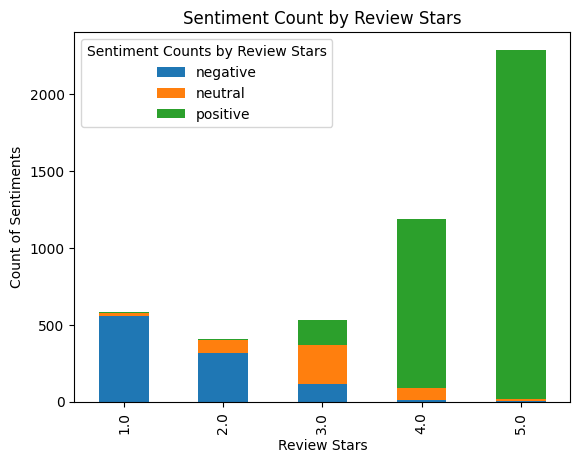

In [46]:
# Aggregate sentiments by review stars
sentiment_counts = test4.groupby(['review_stars', 'hf_sent_label']).size().reset_index(name='total_sentiment')

# Pivot the DataFrame for easier plotting
pivot_df = sentiment_counts.pivot(index='review_stars', columns='hf_sent_label', values='total_sentiment').fillna(0)

# Plotting
pivot_df.plot(kind='bar', stacked=True)
plt.title('Sentiment Count by Review Stars')
plt.xlabel('Review Stars')
plt.ylabel('Count of Sentiments')
plt.legend(title='Sentiment Counts by Review Stars')
plt.show()

This makes a lot of sense since most of the negative sentiment/blue color are in lower ratings and most of the positive sentiment/positive color are in higher ratings with neutral/orange concentrated in center of visualization: rating 3.

In [47]:
# Look at the box plot of sentiment ratios broken down by overall sentiment
# Plot boxplots for text_neg_ratio, text_neu_ratio, and text_pos_ratio broken down by hf_sent_label

# plt.figure(figsize=(15, 5))

# # Plot for text_neg_ratio
# plt.subplot(1, 3, 1)
# sns.boxplot(x='hf_sent_label', y='text_neg_ratio', data=test4)
# plt.title('Boxplot of text_neg_ratio by Sentiment Label')

# # Plot for text_neu_ratio
# plt.subplot(1, 3, 2)
# sns.boxplot(x='hf_sent_label', y='text_neu_ratio', data=test4)
# plt.title('Boxplot of text_neu_ratio by Sentiment Label')

# # Plot for text_pos_ratio
# plt.subplot(1, 3, 3)
# sns.boxplot(x='hf_sent_label', y='text_pos_ratio', data=test4)
# plt.title('Boxplot of text_pos_ratio by Sentiment Label')

# # Adjust layout and show plot
# plt.tight_layout()
# plt.show()

High negative and high positive ratios correspond with neg/pos sentiments. Review sentiment composition gets murky with neutral sentiment since a neutral stance with a restaurant can have a bunch of negative or neutral comments. Would need to look at star rating to get a better view of what sentiment is majority in neutral classified reviews. Let's take a quick peek.

In [48]:
# query = """
# select review_stars
# , clean_text
# , hf_sent_label
# -- , text_neu_ratio
# -- , text_neg_ratio
# -- , text_pos_ratio
# from test4
# where hf_sent_label = 'neutral'
# """

# neutral = duckdb.query(query).df()
# neutral.head(10)

Text mostly is comprised of what:

0. neutral then little neg; neutral ratio correct
1. neg; wrong neg ratio
2. pos and neg (60%); wrong ratio for pos
3. pos, neutral, neg; wrong ratio for pos
4. pos, neg; pos was second
5. neg, pos; neg was low percent
6. neg, pos; neg is lowest ratio
7. pos and neg; pos is higher than neg but neu highest
8. neg, pos; pos has higher ratio than neg but neu highest
9. pos, neg; pos then neg but neu ratio is highest

Mapping review stars to sentiment is difficult because people have varying subjectve definitions for what deserves a 1 versus 5.

In [49]:
# dfr.head()

In [50]:
# Join sample table to dfr to get category and date for review

query = """
select *
from test4
inner join (select review_id as review_id, categories, date from dfr) as dfr
on test4.review_id = dfr.review_id
"""

test5 = duckdb.query(query).df()
test5.head(10)

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,vader_rating,compound,neg,neu,pos,review_id_1,categories,date
0,KIYAHYebXMfL7N943ZDtZA,4.0,great place for sushi! i usually go for happy hour because i think normal prices are a little high but the quality and taste definitely make it worth it. my favorite is the spicy salmon hand roll but you can't really go wrong with anything on the menu! happy hour is 5-7pm. on wednesdays they have happy hour along with $5 hand roll special.,positive,0.993909,"{'neg': 0.0, 'neu': 0.548, 'pos': 0.452, 'compound': 0.9919}",0.9919,0.000,0.548,0.452,KIYAHYebXMfL7N943ZDtZA,"Sushi Bars, Restaurants, Japanese",2019-04-14 14:03:31
1,zpYXR7MHDm7usQ81HFMx7w,5.0,"the food is delicious, and the prices are good. the online ordering was a bit clunky as i had to create an account and get up to find my credit card rather than using the saved info in my phone. it was also confusing because there aren't descriptions of the menu items. i looked at some photos and ordered anyway. i got there, and the open sign was not on, but i went in anyway. my food was ready on time and tastes fresh. the place is clean and the staff is friendly. i got home, and the extra zucchini i ordered seemed like it was a replacement for the other veggies. i thought i was ordering extra, but that is ok. the food is really tasty, and i was able to get lots of yum yum sauce. hibachi is my favorite and it's nice to find an affordable place that does it well.",positive,0.929231,"{'neg': 0.009, 'neu': 0.755, 'pos': 0.236, 'compound': 0.9887}",0.9887,0.009,0.755,0.236,zpYXR7MHDm7usQ81HFMx7w,"Steakhouses, Asian Fusion, Restaurants",2021-07-15 15:44:42
2,vGd32hn86Jj_BPGdT8YbXA,1.0,"this has been one of our favorite restaurants for years. we have always sat in the bar area and enjoyed food and staff. we stopped by to try a meal after this horrible pandemic. the first disappointment was to see the entire bar area and outside seating is not available. the second disappointment was at the hostess stand. after standing there and being ignored for several minutes i believe it was a busser who came up to help. being as we did not have reservations, he shook his head and tried to survey the restaurant. when asked what he was doing he replied trying to space tables and account for being short staffed, and then announced a 45 minute wait. no thanks. we all know how hard it is to run a restaurant in normal times and now it's harder. this ship needs a captain to run it efficiently or it will sink. why would you not have the bar and the outside tables open? obviously you needed space and to run efficiently. why book all available tables, you need to satisfy all customers. we have always just walked in, unless we book for a birthday party. the pandemic can't be blamed for poor planning. get management on the floor running things.",negative,0.915583,"{'neg': 0.098, 'neu': 0.794, 'pos': 0.108, 'compound': 0.5467}",0.5467,0.098,0.794,0.108,vGd32hn86Jj_BPGdT8YbXA,"Restaurants, Italian",2021-07-20 17:32:29
3,yn5F4n3aqvjzPSTCgtjNIQ,5.0,"had a great time stopping by twin peaks last night, the beer was extremely cold and frosted up the glass . i ended up ordering the chipotle chicken and meal come out piping hot, just how i like it!! i sat at the bar with kelsie and brittany, both were attentive and on top of their game. each had a vibrant smile that radiated across the room like an evening sunset on top of a beautiful mountain. the gm, ryan is what i think his name was stopped by and made sure the service and food was up to my liking. then we proceeded to chat about the good ole days playing sports and acknowledging how the old body just doesn't up hold up like it used to. thanks tp",positive,0.985970,"{'neg': 0.024, 'neu': 0.718, 'pos': 0.259, 'compound': 0.9857}",0.9857,0.024,0.718,0.259,yn5F4n3aqvjzPSTCgtjNIQ,"Sports Bars, American (New), American (Traditional), Nightlife, Bars, Restaurants",2020-02-21 14:35:44
4,7dkt6OtfvZfvIiesdzDSmA,4.0,"stylish

In [51]:
# top categories mentioned in reviews
# test5['categories'].value_counts()

In [52]:
# Sentiment breakdown for category; only work with top 5
query = """
select *
from test5
where categories in ('Restaurants, Mexican', 'Restaurants, Pizza', 'Restaurants, Chinese', 'Restaurants, Italian', 'Restaurants, Seafood')
"""

test5 = duckdb.query(query).df()
test5.head(10)

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,vader_rating,compound,neg,neu,pos,review_id_1,categories,date
0,vGd32hn86Jj_BPGdT8YbXA,1.0,"this has been one of our favorite restaurants for years. we have always sat in the bar area and enjoyed food and staff. we stopped by to try a meal after this horrible pandemic. the first disappointment was to see the entire bar area and outside seating is not available. the second disappointment was at the hostess stand. after standing there and being ignored for several minutes i believe it was a busser who came up to help. being as we did not have reservations, he shook his head and tried to survey the restaurant. when asked what he was doing he replied trying to space tables and account for being short staffed, and then announced a 45 minute wait. no thanks. we all know how hard it is to run a restaurant in normal times and now it's harder. this ship needs a captain to run it efficiently or it will sink. why would you not have the bar and the outside tables open? obviously you needed space and to run efficiently. why book all available tables, you need to satisfy all customers. we have always just walked in, unless we book for a birthday party. the pandemic can't be blamed for poor planning. get management on the floor running things.",negative,0.915583,"{'neg': 0.098, 'neu': 0.794, 'pos': 0.108, 'compound': 0.5467}",0.5467,0.098,0.794,0.108,vGd32hn86Jj_BPGdT8YbXA,"Restaurants, Italian",2021-07-20 17:32:29
1,bWgQWwkUiZNc_0cJDLTd4Q,5.0,you gotta go here!!! it's fresh. homemade ingredients. the frijoles charros soup is 'da bomb! don't bother with a cup/get the bowl. everything is fantastic. inexpensive. staff is so sweet. thanks robin for a great dinner in my new spot! you gave me excellent suggestions. i'll be back!,positive,0.997847,"{'neg': 0.049, 'neu': 0.583, 'pos': 0.368, 'compound': 0.9672}",0.9672,0.049,0.583,0.368,bWgQWwkUiZNc_0cJDLTd4Q,"Restaurants, Mexican",2019-04-05 20:14:50
2,ilQZ9nBWpQ5pP6NPm9wnyA,5.0,"pina's pizza is always my go-to pizza place in chalfont when i want something fresh, not papa johns (i'm not saying papa johns isn't delicious). the owners are very friendly and very italian and i love that. the atmosphere just feels like family. i've only ever had their dinner. their salads are great, soups are awesome, the pizza is my favorite (the sauce is sweet and so yummy). i've not had their breakfast since they introduced it but i intend to. their prices are spot on with the other prices in the area. i definitely recommend pina's to anyone looking for some fresh, yummy pizza made by italians that know their stuff!",positive,0.995625,"{'neg': 0.0, 'neu': 0.741, 'pos': 0.259, 'compound': 0.9822}",0.9822,0.000,0.741,0.259,ilQZ9nBWpQ5pP6NPm9wnyA,"Restaurants, Pizza",2014-05-10 22:18:57
3,3ktx44TprYlpTwtjdFlXrw,1.0,it's pretty sad that a place that a place is about one mile from my house takes over 1-1/2 hours to deliver your food. previously had an issue where we ordered snacks and they didn't have what we ordered. instead of letting us know they substituted the order for what they decided was a fair exchange. don't recommend this place.,negative,0.964469,"{'neg': 0.082, 'neu': 0.832, 'pos': 0.086, 'compound': 0.0747}",0.0747,0.082,0.832,0.086,3ktx44TprYlpTwtjdFlXrw,"Restaurants, Pizza",2019-10-02 00:44:55
4,2NSWQDnLjs9Z7ZWOlc_HwA,2.0,"poor service but it depends entirely on which waiter. we've gone there often and the food is better than average (with one exception see below) and had good service, but this trip, it was almost 10 minutes to even get a waiter to come by and give chips and salsa and get drink order (i was 1 minute from just getting up and leaving). the food came for the 3 of us, but not a plate in sight to eat off of when we clearly stated in the beginning that we were sharing the 3 dishes. watching him with other tables, he was clearly only paying attention as it came time to leave a tip, but not at other times during the meal. that being s

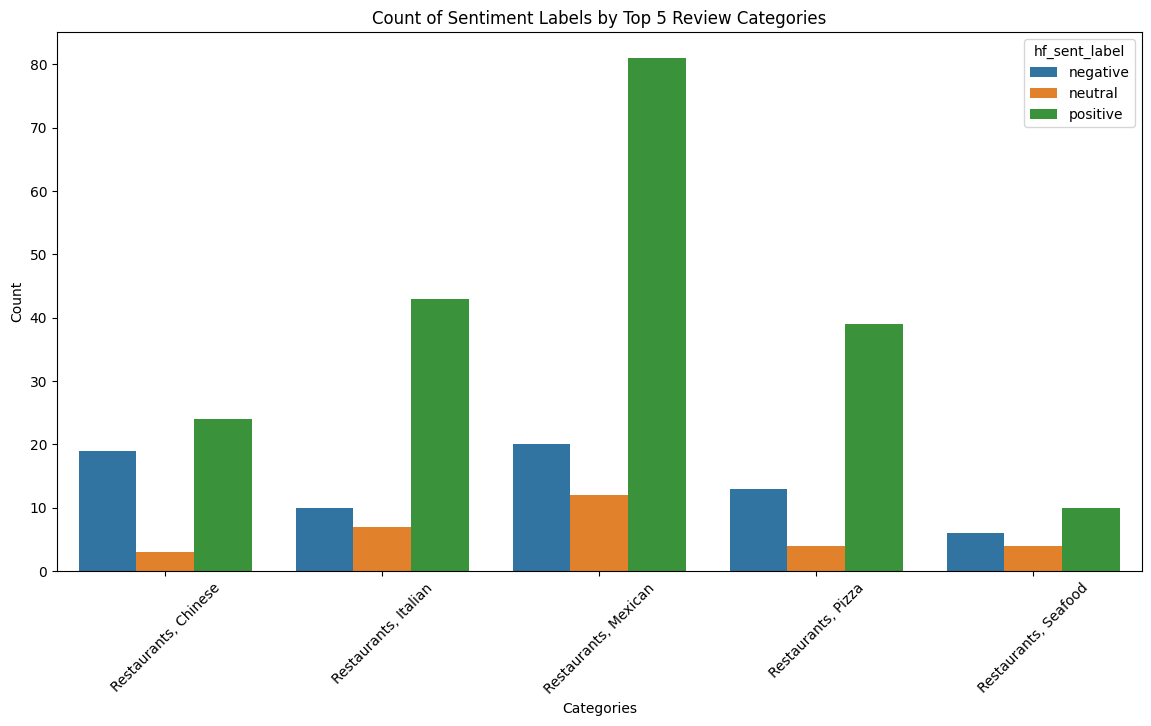

In [53]:
# Group by hf_sent_label and categories and count occurrences
df_grouped = test5.groupby(['hf_sent_label', 'categories']).size().reset_index(name='count')

# Plot the results
plt.figure(figsize=(14, 7))
sns.barplot(x='categories', y='count', hue='hf_sent_label', data=df_grouped)
plt.xticks(rotation=45)
plt.title('Count of Sentiment Labels by Top 5 Review Categories')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.show()

For Mexican Restaurants, positive reviews far outweigh any other cateory.

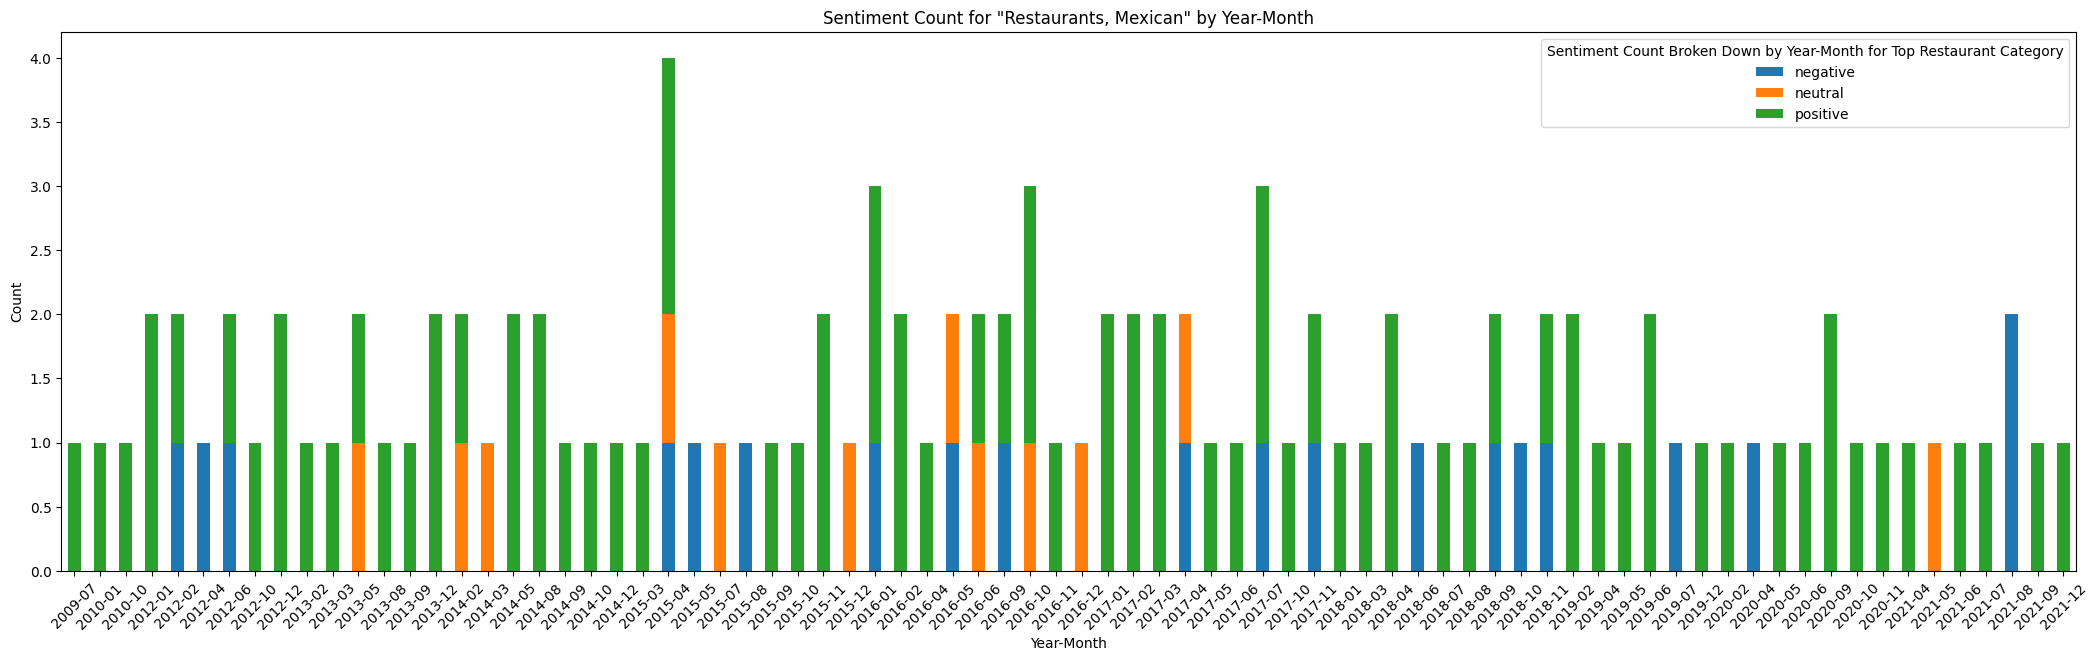

In [54]:
# Sentiment over time for top category: Restaurants, Mexican
# Filter the DataFrame to include only rows where categories is 'Restaurants, Mexican'
df_filtered = test5[test5['categories'] == 'Restaurants, Mexican']

# Convert the date column to datetime
df_filtered['date'] = pd.to_datetime(df_filtered['date'])

# Extract year and month from the date column
df_filtered['year_month'] = df_filtered['date'].dt.to_period('M')

# Group by hf_sent_label and year_month and count occurrences
df_grouped = df_filtered.groupby(['hf_sent_label', 'year_month']).size().reset_index(name='count')

# Pivot the data for plotting
df_pivot = df_grouped.pivot(index='year_month', columns='hf_sent_label', values='count').fillna(0)

# Plot the results
df_pivot.plot(kind='bar', stacked=True, figsize=(26, 7))
plt.title('Sentiment Count for "Restaurants, Mexican" by Year-Month')
plt.xlabel('Year-Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Sentiment Count Broken Down by Year-Month for Top Restaurant Category')
plt.show()

Mexican Restaurant category did best in 2018 spring. Would be interesting to focus in on one particular business and see sentiment trend over time.

And of course we want to know what are the reasons for certain sentiments. 
First, let's look at the most talked about topics in these restaurnt reviews.

# Topic Modeling


Extensive pre-processing need to be done because topic modeling cannot interpret all the text noise as well as Hugging Face LLM's can.

In [55]:
test6 = df_filtered.copy()

In [56]:
# Expand contractions and translate common social acronyms

# Dictionary for contractions
contractions_dict = {
    "i've": "I have",
    "can't": "cannot",
    "won't": "will not",
    "i'm": "I am",
    "you're": "you are",
    "you've": "you have",
    "they're": "they are",
    "we're": "we are",
    "it's": "it is",
    "he's": "he is",
    "she's": "she is",
    "that's": "that is",
    "there's": "there is",
    "isn't": "is not",
    "aren't": "are not",
    "wasn't": "was not",
    "weren't": "were not",
    "haven't": "have not",
    "hasn't": "has not",
    "hadn't": "had not",
    "wouldn't": "would not",
    "shouldn't": "should not",
    "couldn't": "could not",
    "doesn't": "does not",
    "don't": "do not",
    "didn't": "did not",
    "mustn't": "must not",
    "mightn't": "might not",
    "needn't": "need not",
    "you'd": "you would",
    "they'd": "they would",
    "we'd": "we would",
    "she'd": "she would",
    "he'd": "he would",
    "i'd": "I would",
    "it'd": "it would",
    "who'd": "who would",
    "what's": "what is",
    "how's": "how is",
    "let's": "let us",
    "here's": "here is"
}

# Dictionary for social acronyms
acronyms_dict = {
    "lol": "laugh out loud",
    "brb": "be right back",
    "gtg": "got to go",
    "idk": "I do not know",
    "imho": "in my humble opinion",
    "btw": "by the way",
    "omg": "oh my god",
    "ttyl": "talk to you later",
    "afaik": "as far as I know",
    "asap": "as soon as possible",
    "bff": "best friends forever",
    "fyi": "for your information",
    "lmk": "let me know",
    "nvm": "never mind",
    "smh": "shaking my head",
    "tbh": "to be honest",
    "wtf": "what the heck",
    "wth": "what the heck",
    "xoxo": "hugs and kisses"
}

# Combine both dictionaries
combined_dict = {**contractions_dict, **acronyms_dict}

# Function to expand contractions and acronyms
def expand_text(text):
    def replace(match):
        return combined_dict[match.group(0).lower()]

    pattern = re.compile(r'\b(' + '|'.join(re.escape(key) for key in combined_dict.keys()) + r')\b', re.IGNORECASE)
    expanded_text = pattern.sub(replace, text)
    return expanded_text

# Example usage
# text = "I've been busy lol. IDK what's happening, but can't wait to see you!"
# expanded_text = expand_text(text)
# print(expanded_text)

In [57]:
# given context of reviews, need to translate $ and % amounts into english

# def translate_amounts(text):
#     # Define regex patterns for dollar amounts and percentages
#     dollar_pattern = re.compile(r'\$(\d+(\.\d{1,2})?)')
#     percent_pattern = re.compile(r'(\d+(\.\d{1,2})?)%')

#     # Replace dollar amounts with "X dollars"
#     text = dollar_pattern.sub(lambda match: f"{float(match.group(1))} dollars", text)
    
#     # Replace percentages with "X percent"
#     text = percent_pattern.sub(lambda match: f"{float(match.group(1))} percent", text)
    
#     return text

# Example usage
# text = "The price is $4.00 and the discount is 4%."
# translated_text = translate_amounts(text)
# print(translated_text)  # Output: The price is 4.0 dollars and the discount is 4.0 percent.

In [58]:
# def replace_ampersand(text):
#     return text.replace('&', 'and')

# sentence = 'This is a test for &'
# print(replace_ampersand(sentence))

In [59]:
# def remove_punctuation(text):
#     return re.sub(r'[^\w\s]', '', text)

In [60]:
def more_txt_prep(text):
    # Define regex patterns for dollar amounts and percentages
    dollar_pattern = re.compile(r'\$(\d+(\.\d{1,2})?)')
    percent_pattern = re.compile(r'(\d+(\.\d{1,2})?)%')

    # Replace dollar amounts with "X dollars"
    text = dollar_pattern.sub(lambda match: f"{float(match.group(1))} dollars", text)
    
    # Replace percentages with "X percent"
    text = percent_pattern.sub(lambda match: f"{float(match.group(1))} percent", text)
    
    #replace ampersand
    text = text.replace('&', 'and')
    
    # remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    return text

In [61]:
# Some More Text Pre-Processing: tokenize, lemmatize, remove stop words

test6['clean_text2'] = test6.apply(lambda row: expand_text(row.clean_text), axis = 1)
test6['clean_text2'] = test6.apply(lambda row: more_txt_prep(row.clean_text2), axis = 1)
test6['tokenized'] = test6.apply(lambda row: tokenizer.tokenize(row.clean_text2), axis = 1)
test6.head()

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,vader_rating,compound,neg,neu,pos,review_id_1,categories,date,year_month,clean_text2,tokenized
1,bWgQWwkUiZNc_0cJDLTd4Q,5.0,you gotta go here!!! it's fresh. homemade ingredients. the frijoles charros soup is 'da bomb! don't bother with a cup/get the bowl. everything is fantastic. inexpensive. staff is so sweet. thanks robin for a great dinner in my new spot! you gave me excellent suggestions. i'll be back!,positive,0.997847,"{'neg': 0.049, 'neu': 0.583, 'pos': 0.368, 'compound': 0.9672}",0.9672,0.049,0.583,0.368,bWgQWwkUiZNc_0cJDLTd4Q,"Restaurants, Mexican",2019-04-05 20:14:50,2019-04,you gotta go here it is fresh homemade ingredients the frijoles charros soup is da bomb do not bother with a cupget the bowl everything is fantastic inexpensive staff is so sweet thanks robin for a great dinner in my new spot you gave me excellent suggestions ill be back,"[you, gotta, go, here, it, is, fresh, homemade, ingredients, the, fr, ##ij, ##oles, char, ##ros, soup, is, da, bomb, do, not, bother, with, a, cup, ##get, the, bowl, everything, is, fantastic, inexpensive, staff, is, so, sweet, thanks, robin, for, a, great, dinner, in, my, new, spot, you, gave, me, excellent, suggestions, ill, be, back]"
4,2NSWQDnLjs9Z7ZWOlc_HwA,2.0,"poor service but it depends entirely on which waiter. we've gone there often and the food is better than average (with one exception see below) and had good service, but this trip, it was almost 10 minutes to even get a waiter to come by and give chips and salsa and get drink order (i was 1 minute from just getting up and leaving). the food came for the 3 of us, but not a plate in sight to eat off of when we clearly stated in the beginning that we were sharing the 3 dishes. watching him with other tables, he was clearly only paying attention as it came time to leave a tip, but not at other times during the meal. that being said, we have been happy with other wait staff on other visits. the shrimp nachos were a huge disappointment, the limp nachos and less than generous amount of shrimp were buried under a large amount of lettuce. i've never seen lettuce on nachos. we'll be back, but we will watch which waiter serves us.",negative,0.954469,"{'neg': 0.039, 'neu': 0.807, 'pos': 0.154, 'compound': 0.977}",0.9770,0.039,0.807,0.154,2NSWQDnLjs9Z7ZWOlc_HwA,"Restaurants, Mexican",2012-04-29 21:51:20,2012-04,poor service but it depends entirely on which waiter weve gone there often and the food is better than average with one exception see below and had good service but this trip it was almost 10 minutes to even get a waiter to come by and give chips and salsa and get drink order i was 1 minute from just getting up and leaving the food came for the 3 of us but not a plate in sight to eat off of when we clearly stated in the beginning that we were sharing the 3 dishes watching him with other tables he was clearly only paying attention as it came time to leave a tip but not at other times during the meal that being said we have been happy with other wait staff on other visits the shrimp nachos were a huge disappointment the limp nachos and less than generous amount of shrimp were buried under a large amount of lettuce I have never seen lettuce on nachos well be back but we will watch which waiter serves us,"[poor, service, but, it, depends, entirely, on, which, waiter, we, ##ve, gone, there, often, and, the, food, is, better, than, average, with, one, exception, see, below, and, had, good, service, but, this, trip, it, was, almost, 10, minutes, to, even, get, a, waiter, to, come, by, and, give, chips, and, salsa, and, get, drink, order, i, was, 1, minute, from, just, getting, up, and, leaving, the, food, came, for, the, 3, of, us, but, not, a, plate, in, sight, to, eat, off, of, when, we, clearly, stated, in, the, beginning, that, we, were, sharing, the, 3, dishes, watching, him, with, ...]"
5,VhsSJET2_6LKdODsXghP7A,2.0,"strange is just the beginning of our experien

In [62]:
# Function to remove stopwords from a list of tokens
def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    return [word for word in tokens if word.lower() not in stop_words]

# Remove stop words from the 'tokens' column
test6['tokens_no_stopwords'] = test6['tokenized'].apply(remove_stopwords)

test6.head()

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,vader_rating,compound,neg,neu,pos,review_id_1,categories,date,year_month,clean_text2,tokenized,tokens_no_stopwords
1,bWgQWwkUiZNc_0cJDLTd4Q,5.0,you gotta go here!!! it's fresh. homemade ingredients. the frijoles charros soup is 'da bomb! don't bother with a cup/get the bowl. everything is fantastic. inexpensive. staff is so sweet. thanks robin for a great dinner in my new spot! you gave me excellent suggestions. i'll be back!,positive,0.997847,"{'neg': 0.049, 'neu': 0.583, 'pos': 0.368, 'compound': 0.9672}",0.9672,0.049,0.583,0.368,bWgQWwkUiZNc_0cJDLTd4Q,"Restaurants, Mexican",2019-04-05 20:14:50,2019-04,you gotta go here it is fresh homemade ingredients the frijoles charros soup is da bomb do not bother with a cupget the bowl everything is fantastic inexpensive staff is so sweet thanks robin for a great dinner in my new spot you gave me excellent suggestions ill be back,"[you, gotta, go, here, it, is, fresh, homemade, ingredients, the, fr, ##ij, ##oles, char, ##ros, soup, is, da, bomb, do, not, bother, with, a, cup, ##get, the, bowl, everything, is, fantastic, inexpensive, staff, is, so, sweet, thanks, robin, for, a, great, dinner, in, my, new, spot, you, gave, me, excellent, suggestions, ill, be, back]","[gotta, go, fresh, homemade, ingredients, fr, ##ij, ##oles, char, ##ros, soup, da, bomb, bother, cup, ##get, bowl, everything, fantastic, inexpensive, staff, sweet, thanks, robin, great, dinner, new, spot, gave, excellent, suggestions, ill, back]"
4,2NSWQDnLjs9Z7ZWOlc_HwA,2.0,"poor service but it depends entirely on which waiter. we've gone there often and the food is better than average (with one exception see below) and had good service, but this trip, it was almost 10 minutes to even get a waiter to come by and give chips and salsa and get drink order (i was 1 minute from just getting up and leaving). the food came for the 3 of us, but not a plate in sight to eat off of when we clearly stated in the beginning that we were sharing the 3 dishes. watching him with other tables, he was clearly only paying attention as it came time to leave a tip, but not at other times during the meal. that being said, we have been happy with other wait staff on other visits. the shrimp nachos were a huge disappointment, the limp nachos and less than generous amount of shrimp were buried under a large amount of lettuce. i've never seen lettuce on nachos. we'll be back, but we will watch which waiter serves us.",negative,0.954469,"{'neg': 0.039, 'neu': 0.807, 'pos': 0.154, 'compound': 0.977}",0.9770,0.039,0.807,0.154,2NSWQDnLjs9Z7ZWOlc_HwA,"Restaurants, Mexican",2012-04-29 21:51:20,2012-04,poor service but it depends entirely on which waiter weve gone there often and the food is better than average with one exception see below and had good service but this trip it was almost 10 minutes to even get a waiter to come by and give chips and salsa and get drink order i was 1 minute from just getting up and leaving the food came for the 3 of us but not a plate in sight to eat off of when we clearly stated in the beginning that we were sharing the 3 dishes watching him with other tables he was clearly only paying attention as it came time to leave a tip but not at other times during the meal that being said we have been happy with other wait staff on other visits the shrimp nachos were a huge disappointment the limp nachos and less than generous amount of shrimp were buried under a large amount of lettuce I have never seen lettuce on nachos well be back but we will watch which waiter serves us,"[poor, service, but, it, depends, entirely, on, which, waiter, we, ##ve, gone, there, often, and, the, food, is, better, than, average, with, one, exception, see, below, and, had, good, service, but, this, trip, it, was, almost, 10, minutes, to, even, get, a, waiter, to, come, by, and, give, chips, and, salsa, and, get, drink, order, i, was, 1, minute, from, just, getting, up, and, leaving, the, foo

In [63]:
# Function to lemmatize a list of tokens
def lemmatize_tokens(tokens):
    doc = nlp(" ".join(tokens))
    return [token.lemma_ for token in doc]

# Apply the lemmatization function to the 'tokens' column
test6['lemmatized_tokens'] = test6['tokens_no_stopwords'].apply(lemmatize_tokens)

# Display the DataFrame
test6.head()

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,vader_rating,compound,neg,neu,pos,review_id_1,categories,date,year_month,clean_text2,tokenized,tokens_no_stopwords,lemmatized_tokens
1,bWgQWwkUiZNc_0cJDLTd4Q,5.0,you gotta go here!!! it's fresh. homemade ingredients. the frijoles charros soup is 'da bomb! don't bother with a cup/get the bowl. everything is fantastic. inexpensive. staff is so sweet. thanks robin for a great dinner in my new spot! you gave me excellent suggestions. i'll be back!,positive,0.997847,"{'neg': 0.049, 'neu': 0.583, 'pos': 0.368, 'compound': 0.9672}",0.9672,0.049,0.583,0.368,bWgQWwkUiZNc_0cJDLTd4Q,"Restaurants, Mexican",2019-04-05 20:14:50,2019-04,you gotta go here it is fresh homemade ingredients the frijoles charros soup is da bomb do not bother with a cupget the bowl everything is fantastic inexpensive staff is so sweet thanks robin for a great dinner in my new spot you gave me excellent suggestions ill be back,"[you, gotta, go, here, it, is, fresh, homemade, ingredients, the, fr, ##ij, ##oles, char, ##ros, soup, is, da, bomb, do, not, bother, with, a, cup, ##get, the, bowl, everything, is, fantastic, inexpensive, staff, is, so, sweet, thanks, robin, for, a, great, dinner, in, my, new, spot, you, gave, me, excellent, suggestions, ill, be, back]","[gotta, go, fresh, homemade, ingredients, fr, ##ij, ##oles, char, ##ros, soup, da, bomb, bother, cup, ##get, bowl, everything, fantastic, inexpensive, staff, sweet, thanks, robin, great, dinner, new, spot, gave, excellent, suggestions, ill, back]","[get, to, go, fresh, homemade, ingredient, fr, #, #, ij, #, #, ole, char, #, #, ros, soup, da, bomb, bother, cup, #, #, get, bowl, everything, fantastic, inexpensive, staff, sweet, thank, robin, great, dinner, new, spot, give, excellent, suggestion, ill, back]"
4,2NSWQDnLjs9Z7ZWOlc_HwA,2.0,"poor service but it depends entirely on which waiter. we've gone there often and the food is better than average (with one exception see below) and had good service, but this trip, it was almost 10 minutes to even get a waiter to come by and give chips and salsa and get drink order (i was 1 minute from just getting up and leaving). the food came for the 3 of us, but not a plate in sight to eat off of when we clearly stated in the beginning that we were sharing the 3 dishes. watching him with other tables, he was clearly only paying attention as it came time to leave a tip, but not at other times during the meal. that being said, we have been happy with other wait staff on other visits. the shrimp nachos were a huge disappointment, the limp nachos and less than generous amount of shrimp were buried under a large amount of lettuce. i've never seen lettuce on nachos. we'll be back, but we will watch which waiter serves us.",negative,0.954469,"{'neg': 0.039, 'neu': 0.807, 'pos': 0.154, 'compound': 0.977}",0.9770,0.039,0.807,0.154,2NSWQDnLjs9Z7ZWOlc_HwA,"Restaurants, Mexican",2012-04-29 21:51:20,2012-04,poor service but it depends entirely on which waiter weve gone there often and the food is better than average with one exception see below and had good service but this trip it was almost 10 minutes to even get a waiter to come by and give chips and salsa and get drink order i was 1 minute from just getting up and leaving the food came for the 3 of us but not a plate in sight to eat off of when we clearly stated in the beginning that we were sharing the 3 dishes watching him with other tables he was clearly only paying attention as it came time to leave a tip but not at other times during the meal that being said we have been happy with other wait staff on other visits the shrimp nachos were a huge disappointment the limp nachos and less than generous amount of shrimp were buried under a large amount of lettuce I have never seen lettuce on nachos well be back but we will watch which waiter serves us,"[poor, service, but, it, depends, entirely, on, which, waiter, we, ##ve, gone, there, often, and, the, food, is, better, 

In [64]:
# turn cleaned up text column back to strings only

# Function to join list of strings into a single string
def list_to_string(list_of_strings):
    text = ' '.join(list_of_strings)
    return re.sub(r'[^\w\s]', '', text)  # remove punctuation again...

    
test6['clean_text3'] = test6['lemmatized_tokens'].apply(list_to_string)

# Display the DataFrame
test6.head()

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,vader_rating,compound,neg,neu,pos,review_id_1,categories,date,year_month,clean_text2,tokenized,tokens_no_stopwords,lemmatized_tokens,clean_text3
1,bWgQWwkUiZNc_0cJDLTd4Q,5.0,you gotta go here!!! it's fresh. homemade ingredients. the frijoles charros soup is 'da bomb! don't bother with a cup/get the bowl. everything is fantastic. inexpensive. staff is so sweet. thanks robin for a great dinner in my new spot! you gave me excellent suggestions. i'll be back!,positive,0.997847,"{'neg': 0.049, 'neu': 0.583, 'pos': 0.368, 'compound': 0.9672}",0.9672,0.049,0.583,0.368,bWgQWwkUiZNc_0cJDLTd4Q,"Restaurants, Mexican",2019-04-05 20:14:50,2019-04,you gotta go here it is fresh homemade ingredients the frijoles charros soup is da bomb do not bother with a cupget the bowl everything is fantastic inexpensive staff is so sweet thanks robin for a great dinner in my new spot you gave me excellent suggestions ill be back,"[you, gotta, go, here, it, is, fresh, homemade, ingredients, the, fr, ##ij, ##oles, char, ##ros, soup, is, da, bomb, do, not, bother, with, a, cup, ##get, the, bowl, everything, is, fantastic, inexpensive, staff, is, so, sweet, thanks, robin, for, a, great, dinner, in, my, new, spot, you, gave, me, excellent, suggestions, ill, be, back]","[gotta, go, fresh, homemade, ingredients, fr, ##ij, ##oles, char, ##ros, soup, da, bomb, bother, cup, ##get, bowl, everything, fantastic, inexpensive, staff, sweet, thanks, robin, great, dinner, new, spot, gave, excellent, suggestions, ill, back]","[get, to, go, fresh, homemade, ingredient, fr, #, #, ij, #, #, ole, char, #, #, ros, soup, da, bomb, bother, cup, #, #, get, bowl, everything, fantastic, inexpensive, staff, sweet, thank, robin, great, dinner, new, spot, give, excellent, suggestion, ill, back]",get to go fresh homemade ingredient fr ij ole char ros soup da bomb bother cup get bowl everything fantastic inexpensive staff sweet thank robin great dinner new spot give excellent suggestion ill back
4,2NSWQDnLjs9Z7ZWOlc_HwA,2.0,"poor service but it depends entirely on which waiter. we've gone there often and the food is better than average (with one exception see below) and had good service, but this trip, it was almost 10 minutes to even get a waiter to come by and give chips and salsa and get drink order (i was 1 minute from just getting up and leaving). the food came for the 3 of us, but not a plate in sight to eat off of when we clearly stated in the beginning that we were sharing the 3 dishes. watching him with other tables, he was clearly only paying attention as it came time to leave a tip, but not at other times during the meal. that being said, we have been happy with other wait staff on other visits. the shrimp nachos were a huge disappointment, the limp nachos and less than generous amount of shrimp were buried under a large amount of lettuce. i've never seen lettuce on nachos. we'll be back, but we will watch which waiter serves us.",negative,0.954469,"{'neg': 0.039, 'neu': 0.807, 'pos': 0.154, 'compound': 0.977}",0.9770,0.039,0.807,0.154,2NSWQDnLjs9Z7ZWOlc_HwA,"Restaurants, Mexican",2012-04-29 21:51:20,2012-04,poor service but it depends entirely on which waiter weve gone there often and the food is better than average with one exception see below and had good service but this trip it was almost 10 minutes to even get a waiter to come by and give chips and salsa and get drink order i was 1 minute from just getting up and leaving the food came for the 3 of us but not a plate in sight to eat off of when we clearly stated in the beginning that we were sharing the 3 dishes watching him with other tables he was clearly only paying attention as it came time to leave a tip but not at other times during the meal that being said we have been happy with other wait staff on other visits the shrimp nachos were a huge disappointment the limp nachos and less than generous amount of shrimp were buried under a large amount of lettuc

In [65]:
# Now trying topic modeling with cleaned text!
reindexed_data = test6['clean_text3']
tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords.words('english') + ['food', 'ta', 'take'], use_idf=True, smooth_idf=True)
reindexed_data = reindexed_data.values
document_term_matrix = tfidf_vectorizer.fit_transform(reindexed_data)

In [66]:
n_topics = 6
lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(document_term_matrix)

In [67]:
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [68]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

In [69]:
def get_top_n_words(n, keys, document_term_matrix, tfidf_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = tfidf_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

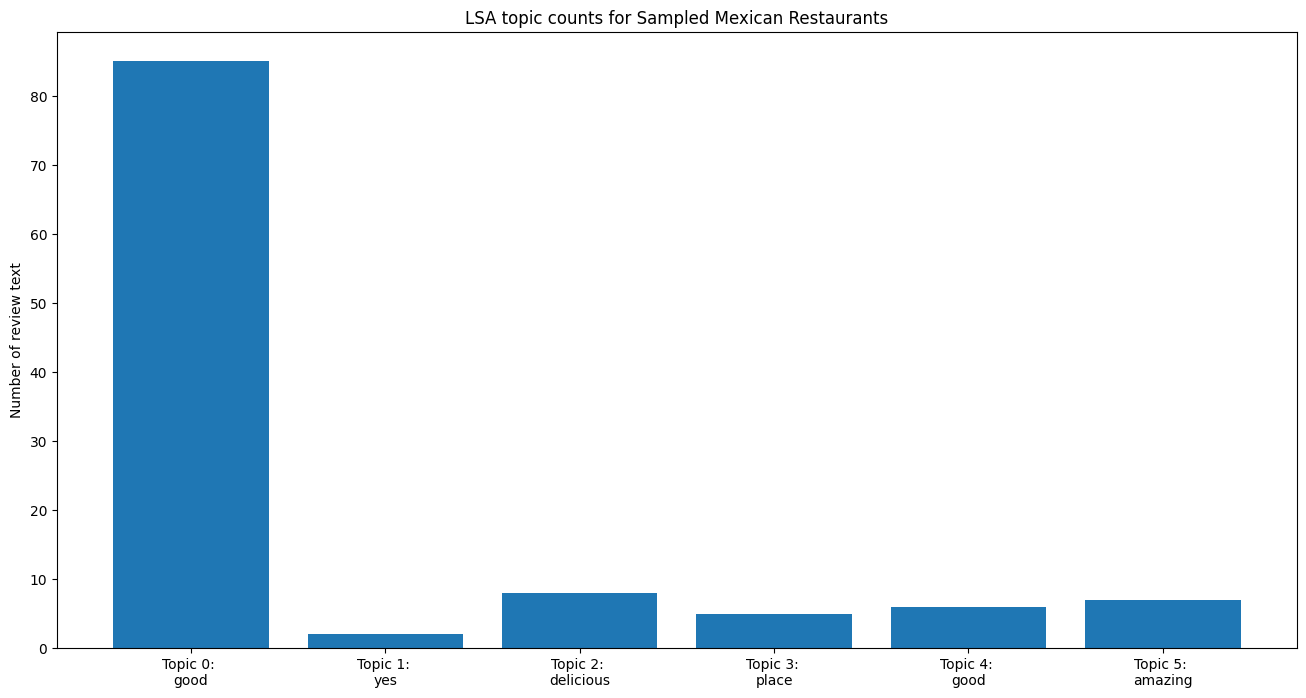

In [70]:
top_3_words = get_top_n_words(1, lsa_keys, document_term_matrix, tfidf_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lsa_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lsa_categories, lsa_counts);
ax.set_xticks(lsa_categories);
ax.set_xticklabels(labels);
ax.set_ylabel('Number of review text');
ax.set_title('LSA topic counts for Sampled Mexican Restaurants');
plt.show();

Not very good interpretation/extraction since Parts of Speech desired should be specified before doing topic modeling and text pre-processing made burrito burr...Trying another method.

In [71]:
# Testing out Algo

# Download NLTK stopwords
# nltk.download('stopwords')

# # Sample Yelp reviews DataFrame
# data = {
#     'review': [
#         "I love the tacos at this place. They're amazing!",
#         "The service was terrible, I will not come back.",
#         "Great atmosphere and friendly staff.",
#         "The food was cold and tasteless.",
#         "I enjoyed my time here, the music was good."
#     ]
# }
# df = pd.DataFrame(data)

# # Preprocess the reviews
# stop_words = set(stopwords.words('english'))
# df['processed'] = df['review'].apply(lambda x: [word for word in x.lower().split() if word not in stop_words])

# # Create a dictionary and corpus
# dictionary = corpora.Dictionary(df['processed'])
# corpus = [dictionary.doc2bow(text) for text in df['processed']]

# # Train the LDA model
# lda_model = LdaModel(corpus, num_topics=3, id2word=dictionary, passes=10)

# # Print the topics
# topics = lda_model.print_topics(num_words=5)
# for topic in topics:
#     print(topic)

1. Each line represets a different topic.
1. Topic can be inferred by given words, 5 total in this case.
1. Numbers next to words are probability that word would be chosen as topic in newly generated text.
1. These topics also cover adjectives. Need to do entity extraction to zoom-in on core review topics. For example, desired output would have been: food, service, ambiance.

Let's see what ouput is from applying this LDA model to Mexican restaurant reviews. 

In [72]:
stop_words = set(stopwords.words('english'))

test6['processed'] =test6['clean_text2'].apply(lambda x: [word for word in x.lower().split() if word not in stop_words])

# Create a dictionary and corpus
dictionary = corpora.Dictionary(test6['processed'])
corpus = [dictionary.doc2bow(text) for text in test6['processed']]

# Train the LDA model
lda_model = LdaModel(corpus, num_topics=3, id2word=dictionary, passes=10)

# Print the topics
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.014*"food" + 0.013*"good" + 0.013*"salsa" + 0.009*"tacos" + 0.009*"great"')
(1, '0.022*"food" + 0.013*"good" + 0.010*"place" + 0.010*"go" + 0.009*"authentic"')
(2, '0.015*"food" + 0.008*"mexican" + 0.007*"would" + 0.007*"tacos" + 0.007*"good"')


Once again, best to get parts of speech/aspects from text and then model the topics. Ideally, would want an ouput that mentions food, service and atmosphere topics with adjetives describing each.

In [73]:
# list of tuples with each tuple having unique word in text and its freq

# # Function to clean and tokenize text
# def tokenize(text):
#     # Convert text to lower case
#     text = text.lower()
#     # Remove punctuation and split by whitespace
#     words = re.findall(r'\b\w+\b', text)
#     return words

# # Apply the tokenize function to the text column and create a Counter
# word_counter = Counter()
# test6['clean_text2'].apply(lambda x: word_counter.update(tokenize(x)))

# # Convert the Counter to a list of tuples (word, frequency)
# word_freq = list(word_counter.items())

# # Display the result
# print(word_freq)

References:
1. https://erickleppen.medium.com/topic-modeling-for-beginners-using-bertopic-and-python-aaf1b421afeb
1. ~~https://maartengr.github.io/BERTopic/getting_started/visualization/visualization.html~~

Trying out BERTopic model. Will try other methods to get different visualizations of topics.

In [74]:
# Trying BERTopic

docs = test6['clean_text2']

# Step 1 - Extract embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Step 2 - Reduce dimensionality
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine')

# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

# Step 4 - Tokenize topics
vectorizer_model = CountVectorizer(stop_words="english")

# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer()

# All steps together

representation_model = MaximalMarginalRelevance(diversity=0.5)
topic_model = BERTopic(
  embedding_model=embedding_model,    # Step 1 - Extract embeddings
  umap_model=umap_model,              # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,        # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,  # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,          # Step 5 - Extract topic words # Diversify topic words
  calculate_probabilities=True,        
  verbose=True,
  representation_model=representation_model
)

topics, probs = topic_model.fit_transform(docs)
topic_model.get_topic_info()

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2024-06-11 02:11:02,372 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

2024-06-11 02:11:07,430 - BERTopic - Embedding - Completed ✓
2024-06-11 02:11:07,432 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-06-11 02:11:20,141 - BERTopic - Dimensionality - Completed ✓
2024-06-11 02:11:20,143 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-06-11 02:11:20,179 - BERTopic - Cluster - Completed ✓
2024-06-11 02:11:20,184 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-06-11 02:11:20,304 - BERTopic - Representation - Completed ✓


,Topic,Count,Name,Representation,Representative_Docs
0,-1,113,-1_mexican_salsa_tacos_restaurant,"[mexican, salsa, tacos, restaurant, like, chips, authentic, burrito, menu, margaritas]","[came here recently for dinner with my husband this mexican restaurant this place is a step up from a fast casual mexican place like chipotle or qdoba but not as nice as a higher end place like el vez it is waiter service but very casual they do not offer complimentary chips and salsa but we decided to get a order the chips and salsa were both really good the salsa is chunkier for dinner i had the chicken quesadilla which was great although not very big it had great flavor unlike some places where you get a chicken quesadilla and it tastes like you could have just made it at home with no seasoning my husband was happy with his meal as well service was good i saw they offer complimentary margaritas but I am not sure if this an actual margarita or just the mixer and you byo the tequila prices were reasonable as well i would definitely go back, we came in for a weekday lunch craving something cold and blended and also something hot and saucy for the former we tried a guava margarita that was advertised on their specials board sooo good it was creamier than most blended margs I have had and the guava flavor was perfect not too overwhelming it did not taste alcoholic in the least but that is not always a bad thing the food menu is extensive since i did not see any options for a combination plate i went with the sopes my better half opted for the enchiladas with al pastor and green sauce we barely had time to sip our margaritas and nibble on the fresh warm chips and spicy salsa before the food arrived it was so quick everything was steaming hot but we dove right in the sope base was crispy on the outside and soft and dense on the inside with plenty of masa flavor permeating through the toppings carnitas lettuce tomato crema and cotija worked in beautiful harmony and made me a very happy panda my boyfriends enchiladas were good but the real shining star of the whole thing was that green enchilada sauce holy tomatillo was it good tangy deep delicious sauce that i could drink by the cup full i highly recommend getting that green sauce on everything the only reason for the missing star is that the rice was basic lacking some flavor and the beans were nothing special i love traditional mexican food but i appreciate when all those good latin spices and flavors are infused in all aspects of the dish overall i really dig this place the service is great the atmosphere is nice and cozy especially for a strip mall restaurant and the food is good and plentiful what is spanish for yum, good food great service and very clean the restaurant is semifast food you order at the counter and they deliver food to your table the place is super clean staff was very helpful with menu and very friendly the salsa bar is very good]"


* The first topic is -1 and contains the most records. This is the outliers topic and should typically be ignored during analysis.
* Let's try another embedder.

In [75]:
%%time

#load the universal sentence encoder model
use4 = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

#generate embeddings
use4_embeddings = use4(test6['clean_text2'])
use= np.array(use4_embeddings)

#create list from np arrays to store the embeddings in the dataframe
test6['use4'] = use.tolist()

#pass the embeddings into BERTopic
topic_model.fit_transform(docs, use)

#get topic info
topic_model.get_topic_info()

2024-06-11 02:11:50,970 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-06-11 02:11:53,983 - BERTopic - Dimensionality - Completed ✓
2024-06-11 02:11:53,984 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-06-11 02:11:54,006 - BERTopic - Cluster - Completed ✓
2024-06-11 02:11:54,011 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-06-11 02:11:54,432 - BERTopic - Representation - Completed ✓


CPU times: user 19.3 s, sys: 5.4 s, total: 24.7 s
Wall time: 33.8 s


,Topic,Count,Name,Representation,Representative_Docs
0,-1,37,-1_service_table_order_shrimp,"[service, table, order, shrimp, restaurant, experience, salsa, staff, friendly, menu]","[the food is very good here some of the best in vail which really is not saying much considering the limited choices this restaurant is poorly managed and the servers are not good they have no training or do not care about service or both if you decide to go set your bar low for service and youll be fine if you go right when they open do not expect food to be fast this place needs a managers attention fast and train your servers on the drink menu if you are going to offer a drink menu I would give this place 1 star but the food is very good which is the only reason i gave it 3, poor service but it depends entirely on which waiter weve gone there often and the food is better than average with one exception see below and had good service but this trip it was almost 10 minutes to even get a waiter to come by and give chips and salsa and get drink order i was 1 minute from just getting up and leaving the food came for the 3 of us but not a plate in sight to eat off of when we clearly stated in the beginning that we were sharing the 3 dishes watching him with other tables he was clearly only paying attention as it came time to leave a tip but not at other times during the meal that being said we have been happy with other wait staff on other visits the shrimp nachos were a huge disappointment the limp nachos and less than generous amount of shrimp were buried under a large amount of lettuce I have never seen lettuce on nachos well be back but we will watch which waiter serves us, good food great service and very clean the restaurant is semifast food you order at the counter and they deliver food to your table the place is super clean staff was very helpful with menu and very friendly the salsa bar is very good]"
1,0,61,0_tacos_salsa_mexican_place,"[tacos, salsa, mexican, place, chips, restaurant, chicken, lunch, delicious, burrito]","[ok I am being really picky and took off a star because i would not eat inside the restaurant it is basically a trailer but it is a great divey mexican joint like joel m said it is right by colbys cocktails bonus that colbys lets you eat in their bar so you cannot miss it right off the clearview 110 service road behind the super 8 plus it is open 24 hours on friday and saturday nights when you have those late night cravings unless you know spanish you will have to point to what you want which is easy because the menu has pictures i ordered a shredded beef and a pork taco on a soft flour tortilla with cheese guacamole and sour cream inside man it was good plus the green sauce has some kick so i gently dipped a little with each bite i definitely want to try all their tacos now plus while we were waiting there some bowls of food that looked delicious and were being served to the patrons inside the restaurant my friends ordered the torta huge football size sandwich tacos and chips and guacamole which everyone enjoyed their respective dishes keep in mind i take it as a good sign when i see hispanic people eating at a mexican joint plus if the people that work there are hispanic and speak spanisheven better one thing i found interesting was they had pupusas which is normally an el salvadorean dish happy mexican eatingmuy delicioso, came here recently for dinner with my husband this mexican restaurant this place is a step up from a fast casual mexican place like chipotle or qdoba but not as nice as a higher end place like el vez it is waiter service but very casual they do not offer complimentary chips and salsa but we decided to get a order the chips and salsa were both really good the salsa is chunkier for dinner i had the chicken quesadilla which was great although not very big it had great flavor unlike some places where you get a chicken quesadilla and it tastes like you could have just made it at home with no seasoning my husb

These different embeddings create topics that make more sense because selected words per topic have a theme:  service, food

In [76]:
topic_model.get_topic(0)

[('tacos', 0.04919571624637799),
 ('salsa', 0.04740989198811225),
 ('mexican', 0.04399607549650919),
 ('place', 0.03696716524096741),
 ('chips', 0.03049603258589245),
 ('restaurant', 0.02540975437823862),
 ('chicken', 0.022381992177268967),
 ('lunch', 0.021446127120368936),
 ('delicious', 0.01876353048821322),
 ('burrito', 0.018382394674601944)]

### Trying Bigger dataset (with top 5 restaurants) to get more topics to avoid visualize_topics error

In [77]:
# %%time

# #load the universal sentence encoder model
# use4 = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

# #generate embeddings
# use4_embeddings = use4(test5['clean_text'])
# use= np.array(use4_embeddings)

# #create list from np arrays to store the embeddings in the dataframe
# test5['use4'] = use.tolist()

# #pass the embeddings into BERTopic
# topic_model.fit_transform(docs, use)

# #get topic info
# topic_model.get_topic_info()

In [78]:
# from hdbscan import HDBSCAN

# hdbscan_model = HDBSCAN(min_cluster_size=20, metric='euclidean', prediction_data=True)
# topic_model = BERTopic(hdbscan_model=hdbscan_model).fit(docs)

In [79]:
# Visualize topics
# topic_model.visualize_topics()

In [80]:
topic_model.visualize_barchart()

In [81]:
topic_model.visualize_heatmap()

# Aspect Extraction: What is being talked about at the review level? - Topics at a more granular level

In [82]:
# get relevant columns
test7 = test6[['review_id',
 'review_stars',
 'clean_text',
 'hf_sent_label',
 'hf_sent_score',
 'review_id_1',
 'categories',
 'clean_text2']]

In [83]:
test7.head()

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,review_id_1,categories,clean_text2
1,bWgQWwkUiZNc_0cJDLTd4Q,5.0,you gotta go here!!! it's fresh. homemade ingredients. the frijoles charros soup is 'da bomb! don't bother with a cup/get the bowl. everything is fantastic. inexpensive. staff is so sweet. thanks robin for a great dinner in my new spot! you gave me excellent suggestions. i'll be back!,positive,0.997847,bWgQWwkUiZNc_0cJDLTd4Q,"Restaurants, Mexican",you gotta go here it is fresh homemade ingredients the frijoles charros soup is da bomb do not bother with a cupget the bowl everything is fantastic inexpensive staff is so sweet thanks robin for a great dinner in my new spot you gave me excellent suggestions ill be back
4,2NSWQDnLjs9Z7ZWOlc_HwA,2.0,"poor service but it depends entirely on which waiter. we've gone there often and the food is better than average (with one exception see below) and had good service, but this trip, it was almost 10 minutes to even get a waiter to come by and give chips and salsa and get drink order (i was 1 minute from just getting up and leaving). the food came for the 3 of us, but not a plate in sight to eat off of when we clearly stated in the beginning that we were sharing the 3 dishes. watching him with other tables, he was clearly only paying attention as it came time to leave a tip, but not at other times during the meal. that being said, we have been happy with other wait staff on other visits. the shrimp nachos were a huge disappointment, the limp nachos and less than generous amount of shrimp were buried under a large amount of lettuce. i've never seen lettuce on nachos. we'll be back, but we will watch which waiter serves us.",negative,0.954469,2NSWQDnLjs9Z7ZWOlc_HwA,"Restaurants, Mexican",poor service but it depends entirely on which waiter weve gone there often and the food is better than average with one exception see below and had good service but this trip it was almost 10 minutes to even get a waiter to come by and give chips and salsa and get drink order i was 1 minute from just getting up and leaving the food came for the 3 of us but not a plate in sight to eat off of when we clearly stated in the beginning that we were sharing the 3 dishes watching him with other tables he was clearly only paying attention as it came time to leave a tip but not at other times during the meal that being said we have been happy with other wait staff on other visits the shrimp nachos were a huge disappointment the limp nachos and less than generous amount of shrimp were buried under a large amount of lettuce I have never seen lettuce on nachos well be back but we will watch which waiter serves us
5,VhsSJET2_6LKdODsXghP7A,2.0,"strange is just the beginning of our experience at el molinito! my boyfriend and i went during lunch and when we asked our server what was his favorite, he said he is forbidden by the owners to try anything because its a small business. (?) very weird. but my green corn tamales were good. my boyfriend's quesadilla was nasty as it was literally american cheese which is weird to put on a quesadilla. don't recommend it.",neutral,0.497880,VhsSJET2_6LKdODsXghP7A,"Restaurants, Mexican",strange is just the beginning of our experience at el molinito my boyfriend and i went during lunch and when we asked our server what was his favorite he said he is forbidden by the owners to try anything because its a small business very weird but my green corn tamales were good my boyfriends quesadilla was nasty as it was literally american cheese which is weird to put on a quesadilla do not recommend it
12,SmgaDV8fePFRzJHWR8LgPQ,1.0,"this place is a shining example of mediocrity. my fajitas texana came out lukewarm. my sister ordered a chimichanga. it had a cooked toothpick wrapped inside the chimichanga! we still got to pay full price though. i mean, we're not trying to rip anyone off, but after finding a sharp wooden toothpick which (presumably) fell out of the cook's mouth (be

# Aspect-based Sentiment Analysis/Opinion Mining
With aspect-based sentiment analysis, can get a better idea on what led to Vader's neg, neutral and pos ratios from each review.

In [84]:
# get small sample of reviews to test algo on
sample = test7.head(5)
sample

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,review_id_1,categories,clean_text2
1,bWgQWwkUiZNc_0cJDLTd4Q,5.0,you gotta go here!!! it's fresh. homemade ingredients. the frijoles charros soup is 'da bomb! don't bother with a cup/get the bowl. everything is fantastic. inexpensive. staff is so sweet. thanks robin for a great dinner in my new spot! you gave me excellent suggestions. i'll be back!,positive,0.997847,bWgQWwkUiZNc_0cJDLTd4Q,"Restaurants, Mexican",you gotta go here it is fresh homemade ingredients the frijoles charros soup is da bomb do not bother with a cupget the bowl everything is fantastic inexpensive staff is so sweet thanks robin for a great dinner in my new spot you gave me excellent suggestions ill be back
4,2NSWQDnLjs9Z7ZWOlc_HwA,2.0,"poor service but it depends entirely on which waiter. we've gone there often and the food is better than average (with one exception see below) and had good service, but this trip, it was almost 10 minutes to even get a waiter to come by and give chips and salsa and get drink order (i was 1 minute from just getting up and leaving). the food came for the 3 of us, but not a plate in sight to eat off of when we clearly stated in the beginning that we were sharing the 3 dishes. watching him with other tables, he was clearly only paying attention as it came time to leave a tip, but not at other times during the meal. that being said, we have been happy with other wait staff on other visits. the shrimp nachos were a huge disappointment, the limp nachos and less than generous amount of shrimp were buried under a large amount of lettuce. i've never seen lettuce on nachos. we'll be back, but we will watch which waiter serves us.",negative,0.954469,2NSWQDnLjs9Z7ZWOlc_HwA,"Restaurants, Mexican",poor service but it depends entirely on which waiter weve gone there often and the food is better than average with one exception see below and had good service but this trip it was almost 10 minutes to even get a waiter to come by and give chips and salsa and get drink order i was 1 minute from just getting up and leaving the food came for the 3 of us but not a plate in sight to eat off of when we clearly stated in the beginning that we were sharing the 3 dishes watching him with other tables he was clearly only paying attention as it came time to leave a tip but not at other times during the meal that being said we have been happy with other wait staff on other visits the shrimp nachos were a huge disappointment the limp nachos and less than generous amount of shrimp were buried under a large amount of lettuce I have never seen lettuce on nachos well be back but we will watch which waiter serves us
5,VhsSJET2_6LKdODsXghP7A,2.0,"strange is just the beginning of our experience at el molinito! my boyfriend and i went during lunch and when we asked our server what was his favorite, he said he is forbidden by the owners to try anything because its a small business. (?) very weird. but my green corn tamales were good. my boyfriend's quesadilla was nasty as it was literally american cheese which is weird to put on a quesadilla. don't recommend it.",neutral,0.497880,VhsSJET2_6LKdODsXghP7A,"Restaurants, Mexican",strange is just the beginning of our experience at el molinito my boyfriend and i went during lunch and when we asked our server what was his favorite he said he is forbidden by the owners to try anything because its a small business very weird but my green corn tamales were good my boyfriends quesadilla was nasty as it was literally american cheese which is weird to put on a quesadilla do not recommend it
12,SmgaDV8fePFRzJHWR8LgPQ,1.0,"this place is a shining example of mediocrity. my fajitas texana came out lukewarm. my sister ordered a chimichanga. it had a cooked toothpick wrapped inside the chimichanga! we still got to pay full price though. i mean, we're not trying to rip anyone off, but after finding a sharp wooden toothpick which (presumably) fell out of the cook's mouth (be

### Get Aspects from clean_text. Let us target food, the service, then ambiance

In [85]:
# Let us try HuggingFace model since MonkeyLearn had sign-up/API issues

from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

model_name = "yangheng/deberta-v3-large-absa-v1.1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)

tokenizer_config.json:   0%|          | 0.00/397 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/18.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

In [86]:
aspects = ["food", "service", "ambience"]

text = """
the service was absolutely horrible. 
the restaurant was not very busy, and yet we waited over 1 hour for our food. 
would not recommend if you are expecting good service. 
additionally, the food was very sub par. the draft beer was flat, 
and the other drinks were nothing special. 
would advise elsewhere for mexican food.
"""

for aspect in aspects:
   print(aspect, classifier(text,  text_pair=aspect))

food [{'label': 'Negative', 'score': 0.8268147110939026}]
service [{'label': 'Negative', 'score': 0.9997759461402893}]
ambience [{'label': 'Negative', 'score': 0.9601736664772034}]


Not sure about negative ambiance since this was not explicitly talked about in review. Let's try others.

In [87]:
aspects = ["food", "service", "ambiance"]

text = """
so we went to this restaurant last night as we were looking for more authentic mexican. 
we'd been there once before when they first opened. 
had to say, we were pretty blown away by how good it was--there were 5 of us, and everything was excellent--literally excellent. 
we had the shrimp ceviche, shrimp tacos, the chicken nachos, chicken burrito, chicken tacos and then the chorizos for dessert (warm, right out of the oven!). 
all were made with fresh ingredients, were of large portion sizes and best of all the seasonings and flavors were superb. 
they brought us a great pitcher of margarita mix (which was excellent as well) and went nicely with our sauza to make great margaritas in the large glasses they provide for them. 
i have to say this is a rare gem of a find, highly worth it, and we are already telling people to go there. total bill for 5 people was $125 too--a real bargain. 
plus the setting was very nice, sitting on the streets of haddonfield, well-shaded. staff/service was on point too--attentive and very prompt. great place.
"""

for aspect in aspects:
   print(aspect, classifier(text,  text_pair=aspect))

food [{'label': 'Positive', 'score': 0.997377872467041}]
service [{'label': 'Positive', 'score': 0.9996957778930664}]
ambiance [{'label': 'Positive', 'score': 0.9966110587120056}]


This time around, ambiance was mentioned as "setting" and positive sentiment detected.

In [88]:
aspects = ["food", "service", "ambiance"]

text = """
amazing food!!! 
looks like a hole in the wall kind of place but those are always the hidden gems. 
the stuff the tacos, so i was full off of three! 
they were quick and efficient. 
loved it!
"""

for aspect in aspects:
   print(aspect, classifier(text,  text_pair=aspect))

food [{'label': 'Positive', 'score': 0.9999120235443115}]
service [{'label': 'Positive', 'score': 0.9970831274986267}]
ambiance [{'label': 'Positive', 'score': 0.9277939200401306}]


## Really cool how predictive model was able to determine aspects in review and determine sentiment. 
### Next step is determine what caused aspect sentiment specifically from review. For example, tacos were food aspect that led to positive sentiment for food.

In [89]:
# Maybe get key aspects first that fit under food, service and ambiance. Then get descriptors. And from their classify review with sentiment.

# Trying PyABSA again

In [90]:
# from pyabsa import available_checkpoints
# checkpoint_map = available_checkpoints(from_local=False)

In [91]:
from pyabsa import ATEPCCheckpointManager

aspect_extractor = ATEPCCheckpointManager.get_aspect_extractor(checkpoint='english',
                                   auto_device=True  # False means load model on CPU
                                   )

/bin/sh: 1: nvidia-smi: not found


No CUDA GPU found in your device
[2024-06-11 02:12:27] (2.4.1.post1) PyABSA(2.4.1.post1): If your code crashes on Colab, please use the GPU runtime. Then run "pip install pyabsa[dev] -U" and restart the kernel.
Or if it does not work, you can use v1.x versions, e.g., pip install pyabsa<2.0 -U




Try to downgrade transformers<=4.29.0.






/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/opt/conda/lib/python3.10/multiprocessing/pool.py:268: ResourceWarning:

unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=1>



[2024-06-11 02:12:37] (2.4.1.post1) ********** Available ATEPC model checkpoints for Version:2.4.1.post1 (this version) **********
[2024-06-11 02:12:37] (2.4.1.post1) ********** Available ATEPC model checkpoints for Version:2.4.1.post1 (this version) **********
[2024-06-11 02:12:37] (2.4.1.post1) Downloading checkpoint:english 
[2024-06-11 02:12:37] (2.4.1.post1) Notice: The pretrained model are used for testing, it is recommended to train the model on your own custom datasets


Find zipped checkpoint: ./checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43.zip, unzipping


Done.
[2024-06-11 02:13:05] (2.4.1.post1) If the auto-downloading failed, please download it via browser: https://huggingface.co/spaces/yangheng/PyABSA/resolve/main/checkpoints/English/ATEPC/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43.zip 
[2024-06-11 02:13:05] (2.4.1.post1) Load aspect extractor from checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43
[2024-06-11 02:13:05] (2.4.1.post1) config: checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43/fast_lcf_atepc.config
[2024-06-11 02:13:05] (2.4.1.post1) state_dict: checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43/fast_lcf_atepc.state_dict
[2024-06-11 02:13:05] (2.4.1.post1) model: None
[2024-06-11 02:13:05] (2.4.1.post1) tokenizer: checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43/fast_lcf_atepc.tokenizer
[2024-06-11 0

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning:

The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.



config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()



tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:550: UserWarning:

The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.



In [92]:
# You can inference from a list of setences or a DatasetItem from PyABSA 
examples = ['Staff was very rude but food was delicious']
inference_source = examples
atepc_result = aspect_extractor.extract_aspect(inference_source=inference_source,  #
                          pred_sentiment=True,  # Predict the sentiment of extracted aspect terms
                          )

/opt/conda/lib/python3.10/site-packages/pyabsa/tasks/AspectTermExtraction/prediction/aspect_extractor.py:593: UserWarning:

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)



[2024-06-11 02:13:16] (2.4.1.post1) The results of aspect term extraction have been saved in /kaggle/working/Aspect Term Extraction and Polarity Classification.FAST_LCF_ATEPC.result.json
[2024-06-11 02:13:16] (2.4.1.post1) Example 0: Staff was very rude but <food:Positive Confidence:0.9994> was delicious


In [93]:
atepc_result

[{'sentence': 'Staff was very rude but food was delicious',
  'IOB': ['B-ASP', 'O', 'O', 'O', 'O', 'B-ASP', 'O', 'O'],
  'tokens': ['Staff',
   'was',
   'very',
   'rude',
   'but',
   'food',
   'was',
   'delicious'],
  'aspect': ['Staff', 'food'],
  'position': [[0], [5]],
  'sentiment': ['Negative', 'Positive'],
  'probs': [[0.9969356060028076, 0.0028198729269206524, 0.0002444849524181336],
   [0.0003258804208599031, 0.0002935871889349073, 0.9993804693222046]],
  'confidence': [0.9969, 0.9994]}]

In [94]:
# Now let us try out couple of the yelp reviews
examples = ['''so we went to this restaurant last night as we were looking for more authentic mexican. 
we'd been there once before when they first opened. 
had to say, we were pretty blown away by how good it was--there were 5 of us, and everything was excellent--literally excellent. 
we had the shrimp ceviche, shrimp tacos, the chicken nachos, chicken burrito, chicken tacos and then the chorizos for dessert (warm, right out of the oven!). 
all were made with fresh ingredients, were of large portion sizes and best of all the seasonings and flavors were superb. 
they brought us a great pitcher of margarita mix (which was excellent as well) and went nicely with our sauza to make great margaritas in the large glasses they provide for them. 
i have to say this is a rare gem of a find, highly worth it, and we are already telling people to go there. total bill for 5 people was $125 too--a real bargain. 
plus the setting was very nice, sitting on the streets of haddonfield, well-shaded. staff/service was on point too--attentive and very prompt. great place.''']

atepc_result2 = aspect_extractor.extract_aspect(inference_source=examples,  #
                          pred_sentiment=True,  # Predict the sentiment of extracted aspect terms
                          )

[2024-06-11 02:13:25] (2.4.1.post1) The results of aspect term extraction have been saved in /kaggle/working/Aspect Term Extraction and Polarity Classification.FAST_LCF_ATEPC.result.json
[2024-06-11 02:13:25] (2.4.1.post1) Example 0: so we went to this restaurant last night as we were looking for more authentic mexican . we ' d been there once before when they first opened . had to say , we were pretty blown away by how good <it:Positive Confidence:0.9987> was - - there were 5 of us , and everything was excellent - - literally excellent . we had the shrimp <ceviche:Positive Confidence:0.9959> , shrimp tacos , the chicken nachos , chicken burrito , chicken tacos and then the chorizos for dessert ( warm , right out of the oven ! ) . all were made with fresh ingredients , were of large <portion:Positive Confidence:0.9991> sizes and best of all the seasonings and <flavors:Positive Confidence:0.9991> were superb . they brought us a great pitcher of <margarita mix:Positive Confidence:0.9991>

In [95]:
# atepc_result2

In [96]:
# get relevant columns from sample df
query = """
select review_id
, review_stars
, clean_text
, hf_sent_label
, hf_sent_score
, categories
from sample
"""

sample2 = duckdb.query(query).df()
sample2

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,categories
0,bWgQWwkUiZNc_0cJDLTd4Q,5.0,you gotta go here!!! it's fresh. homemade ingredients. the frijoles charros soup is 'da bomb! don't bother with a cup/get the bowl. everything is fantastic. inexpensive. staff is so sweet. thanks robin for a great dinner in my new spot! you gave me excellent suggestions. i'll be back!,positive,0.997847,"Restaurants, Mexican"
1,2NSWQDnLjs9Z7ZWOlc_HwA,2.0,"poor service but it depends entirely on which waiter. we've gone there often and the food is better than average (with one exception see below) and had good service, but this trip, it was almost 10 minutes to even get a waiter to come by and give chips and salsa and get drink order (i was 1 minute from just getting up and leaving). the food came for the 3 of us, but not a plate in sight to eat off of when we clearly stated in the beginning that we were sharing the 3 dishes. watching him with other tables, he was clearly only paying attention as it came time to leave a tip, but not at other times during the meal. that being said, we have been happy with other wait staff on other visits. the shrimp nachos were a huge disappointment, the limp nachos and less than generous amount of shrimp were buried under a large amount of lettuce. i've never seen lettuce on nachos. we'll be back, but we will watch which waiter serves us.",negative,0.954469,"Restaurants, Mexican"
2,VhsSJET2_6LKdODsXghP7A,2.0,"strange is just the beginning of our experience at el molinito! my boyfriend and i went during lunch and when we asked our server what was his favorite, he said he is forbidden by the owners to try anything because its a small business. (?) very weird. but my green corn tamales were good. my boyfriend's quesadilla was nasty as it was literally american cheese which is weird to put on a quesadilla. don't recommend it.",neutral,0.497880,"Restaurants, Mexican"
3,SmgaDV8fePFRzJHWR8LgPQ,1.0,"this place is a shining example of mediocrity. my fajitas texana came out lukewarm. my sister ordered a chimichanga. it had a cooked toothpick wrapped inside the chimichanga! we still got to pay full price though. i mean, we're not trying to rip anyone off, but after finding a sharp wooden toothpick which (presumably) fell out of the cook's mouth (because how else cook it get there?) and landed in the food he was preparing, and then found after taking a couple bites-- i would have thought something with more sincerity than an ""oops!! would you like another?"" would be said.",negative,0.934823,"Restaurants, Mexican"
4,JIwQ3pEW9AERk-0A9Y3ZOA,3.0,"great steak my server was good people but the front door telling me ten minute to be seated and lasted for 50 minute! so thinking i was going to be seated shortly, but we waited and waited. after being totally upset i finally got our table. the ribeye was very good the whole meal had had a ton of sodium, but was delicious. if you have high blood pressure stay away from this place! i can recommend the steak but no one handling seating! on the other hand the server treated us well. our waitress was very nice and friendly! my overall rating would be for 4 stars but only because i haven't tried all the foods. it was the people ( young ladies ) at the front door that put a sour taste in my mouth. no one should be lied to, or dragged along! i do not like going to eat my dinner while i am angry.",neutral,0.629910,"Restaurants, Mexican"


# Add to df general aspects-defined sentiment

In [97]:
analyzer = SentimentIntensityAnalyzer()
test2['vader_rating'] = sample2['clean_text'].apply(analyzer.polarity_scores)

In [98]:
aspects = ["food", "service", "ambience"]

text = """
the service was absolutely horrible. 
the restaurant was not very busy, and yet we waited over 1 hour for our food. 
would not recommend if you are expecting good service. 
additionally, the food was very sub par. the draft beer was flat, 
and the other drinks were nothing special. 
would advise elsewhere for mexican food.
"""
d = {}
for aspect in aspects:
    d[aspect] = classifier(text,  text_pair=aspect)[0].get('label')
d

{'food': 'Negative', 'service': 'Negative', 'ambience': 'Negative'}

In [99]:
aspects = ["food", "service", "ambience"]

def absa_general(text):

    d = {}
    for aspect in aspects:
        d[aspect] = classifier(text,  text_pair=aspect)[0].get('label')
    return d

sample2['absa_gen'] = sample2.apply(lambda row: absa_general(row['clean_text']), axis=1)

In [100]:
sample2

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,categories,absa_gen
0,bWgQWwkUiZNc_0cJDLTd4Q,5.0,you gotta go here!!! it's fresh. homemade ingredients. the frijoles charros soup is 'da bomb! don't bother with a cup/get the bowl. everything is fantastic. inexpensive. staff is so sweet. thanks robin for a great dinner in my new spot! you gave me excellent suggestions. i'll be back!,positive,0.997847,"Restaurants, Mexican","{'food': 'Positive', 'service': 'Positive', 'ambience': 'Positive'}"
1,2NSWQDnLjs9Z7ZWOlc_HwA,2.0,"poor service but it depends entirely on which waiter. we've gone there often and the food is better than average (with one exception see below) and had good service, but this trip, it was almost 10 minutes to even get a waiter to come by and give chips and salsa and get drink order (i was 1 minute from just getting up and leaving). the food came for the 3 of us, but not a plate in sight to eat off of when we clearly stated in the beginning that we were sharing the 3 dishes. watching him with other tables, he was clearly only paying attention as it came time to leave a tip, but not at other times during the meal. that being said, we have been happy with other wait staff on other visits. the shrimp nachos were a huge disappointment, the limp nachos and less than generous amount of shrimp were buried under a large amount of lettuce. i've never seen lettuce on nachos. we'll be back, but we will watch which waiter serves us.",negative,0.954469,"Restaurants, Mexican","{'food': 'Positive', 'service': 'Negative', 'ambience': 'Negative'}"
2,VhsSJET2_6LKdODsXghP7A,2.0,"strange is just the beginning of our experience at el molinito! my boyfriend and i went during lunch and when we asked our server what was his favorite, he said he is forbidden by the owners to try anything because its a small business. (?) very weird. but my green corn tamales were good. my boyfriend's quesadilla was nasty as it was literally american cheese which is weird to put on a quesadilla. don't recommend it.",neutral,0.497880,"Restaurants, Mexican","{'food': 'Neutral', 'service': 'Negative', 'ambience': 'Negative'}"
3,SmgaDV8fePFRzJHWR8LgPQ,1.0,"this place is a shining example of mediocrity. my fajitas texana came out lukewarm. my sister ordered a chimichanga. it had a cooked toothpick wrapped inside the chimichanga! we still got to pay full price though. i mean, we're not trying to rip anyone off, but after finding a sharp wooden toothpick which (presumably) fell out of the cook's mouth (because how else cook it get there?) and landed in the food he was preparing, and then found after taking a couple bites-- i would have thought something with more sincerity than an ""oops!! would you like another?"" would be said.",negative,0.934823,"Restaurants, Mexican","{'food': 'Neutral', 'service': 'Negative', 'ambience': 'Negative'}"
4,JIwQ3pEW9AERk-0A9Y3ZOA,3.0,"great steak my server was good people but the front door telling me ten minute to be seated and lasted for 50 minute! so thinking i was going to be seated shortly, but we waited and waited. after being totally upset i finally got our table. the ribeye was very good the whole meal had had a ton of sodium, but was delicious. if you have high blood pressure stay away from this place! i can recommend the steak but no one handling seating! on the other hand the server treated us well. our waitress was very nice and friendly! my overall rating would be for 4 stars but only because i haven't tried all the foods. it was the people ( young ladies ) at the front door that put a sour taste in my mouth. no one should be lied to, or dragged along! i do not like going to eat my dinner while i am angry.",neutral,0.629910,"Restaurants, Mexican","{'food': 'Negative', 'service': 'Negative', 'ambience': 'Negative'}"


In [101]:
# Extract keys and create new columns
for key in sample2['absa_gen'][0].keys():
    sample2[key] = sample2['absa_gen'].apply(lambda x: x[key])

# Display the updated DataFrame
sample2

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,categories,absa_gen,food,service,ambience
0,bWgQWwkUiZNc_0cJDLTd4Q,5.0,you gotta go here!!! it's fresh. homemade ingredients. the frijoles charros soup is 'da bomb! don't bother with a cup/get the bowl. everything is fantastic. inexpensive. staff is so sweet. thanks robin for a great dinner in my new spot! you gave me excellent suggestions. i'll be back!,positive,0.997847,"Restaurants, Mexican","{'food': 'Positive', 'service': 'Positive', 'ambience': 'Positive'}",Positive,Positive,Positive
1,2NSWQDnLjs9Z7ZWOlc_HwA,2.0,"poor service but it depends entirely on which waiter. we've gone there often and the food is better than average (with one exception see below) and had good service, but this trip, it was almost 10 minutes to even get a waiter to come by and give chips and salsa and get drink order (i was 1 minute from just getting up and leaving). the food came for the 3 of us, but not a plate in sight to eat off of when we clearly stated in the beginning that we were sharing the 3 dishes. watching him with other tables, he was clearly only paying attention as it came time to leave a tip, but not at other times during the meal. that being said, we have been happy with other wait staff on other visits. the shrimp nachos were a huge disappointment, the limp nachos and less than generous amount of shrimp were buried under a large amount of lettuce. i've never seen lettuce on nachos. we'll be back, but we will watch which waiter serves us.",negative,0.954469,"Restaurants, Mexican","{'food': 'Positive', 'service': 'Negative', 'ambience': 'Negative'}",Positive,Negative,Negative
2,VhsSJET2_6LKdODsXghP7A,2.0,"strange is just the beginning of our experience at el molinito! my boyfriend and i went during lunch and when we asked our server what was his favorite, he said he is forbidden by the owners to try anything because its a small business. (?) very weird. but my green corn tamales were good. my boyfriend's quesadilla was nasty as it was literally american cheese which is weird to put on a quesadilla. don't recommend it.",neutral,0.497880,"Restaurants, Mexican","{'food': 'Neutral', 'service': 'Negative', 'ambience': 'Negative'}",Neutral,Negative,Negative
3,SmgaDV8fePFRzJHWR8LgPQ,1.0,"this place is a shining example of mediocrity. my fajitas texana came out lukewarm. my sister ordered a chimichanga. it had a cooked toothpick wrapped inside the chimichanga! we still got to pay full price though. i mean, we're not trying to rip anyone off, but after finding a sharp wooden toothpick which (presumably) fell out of the cook's mouth (because how else cook it get there?) and landed in the food he was preparing, and then found after taking a couple bites-- i would have thought something with more sincerity than an ""oops!! would you like another?"" would be said.",negative,0.934823,"Restaurants, Mexican","{'food': 'Neutral', 'service': 'Negative', 'ambience': 'Negative'}",Neutral,Negative,Negative
4,JIwQ3pEW9AERk-0A9Y3ZOA,3.0,"great steak my server was good people but the front door telling me ten minute to be seated and lasted for 50 minute! so thinking i was going to be seated shortly, but we waited and waited. after being totally upset i finally got our table. the ribeye was very good the whole meal had had a ton of sodium, but was delicious. if you have high blood pressure stay away from this place! i can recommend the steak but no one handling seating! on the other hand the server treated us well. our waitress was very nice and friendly! my overall rating would be for 4 stars but only because i haven't tried all the foods. it was the people ( young ladies ) at the front door that put a sour taste in my mouth. no one should be lied to, or dragged along! i do not like going to eat my dinner while i am angry.",neutral,0.629910,"Restaurants, Mexican","{'food': 'Negative', 'service': 'Negative', 'ambience': 'Negative'}",Negative,Negative,Negative


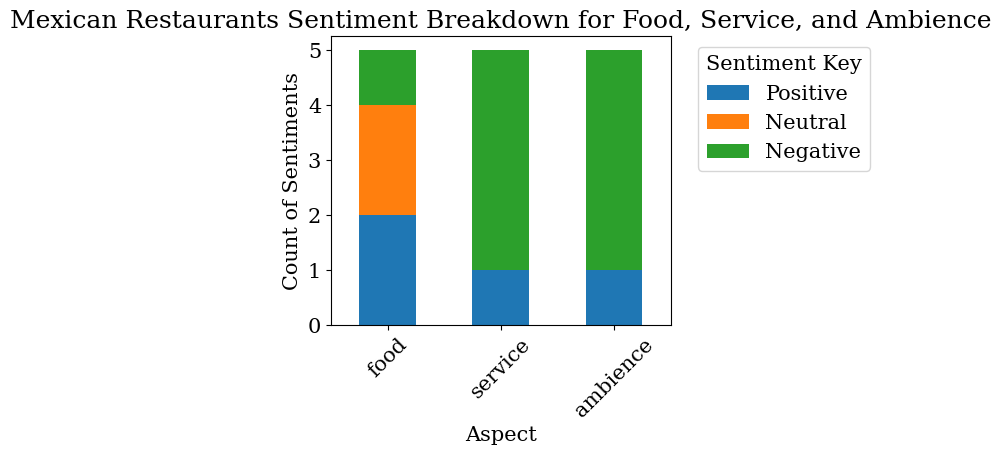

In [102]:
# Extract keys and create new columns
for key in sample2['absa_gen'][0].keys():
    sample2[key] = sample2['absa_gen'].apply(lambda x: x[key])

# Count occurrences of each sentiment for food, service, and ambience
sentiments = ['Positive', 'Neutral', 'Negative']
aspects = ['food', 'service', 'ambience']

# Initialize an empty dictionary to hold the sentiment counts
sentiment_counts = {aspect: {sentiment: 0 for sentiment in sentiments} for aspect in aspects}

# Populate the sentiment counts
for aspect in aspects:
    counts = sample2[aspect].value_counts()
    for sentiment in sentiments:
        if sentiment in counts:
            sentiment_counts[aspect][sentiment] = counts[sentiment]

# Create a DataFrame from sentiment counts
sentiment_df = pd.DataFrame(sentiment_counts)

# Plot the stacked bar chart
sentiment_df.T.plot(kind='bar', stacked=True)

# Customize the chart
plt.title('Mexican Restaurants Sentiment Breakdown for Food, Service, and Ambience')
plt.xlabel('Aspect')
plt.ylabel('Count of Sentiments')
plt.xticks(rotation=45)

# Place the legend outside the plot
plt.legend(title='Sentiment Key', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust the layout to make room for the legend
plt.tight_layout()

# Show the plot
plt.show()

# Add PyABSA on sample's reviews

In [103]:
# You can inference from a list of setences or a DatasetItem from PyABSA 
examples = ['Staff was very rude but food was delicious']
inference_source = examples
atepc_result = aspect_extractor.extract_aspect(inference_source=inference_source,  #
                          pred_sentiment=True,  # Predict the sentiment of extracted aspect terms
                          )

[2024-06-11 02:13:58] (2.4.1.post1) The results of aspect term extraction have been saved in /kaggle/working/Aspect Term Extraction and Polarity Classification.FAST_LCF_ATEPC.result.json
[2024-06-11 02:13:58] (2.4.1.post1) Example 0: Staff was very rude but <food:Positive Confidence:0.9994> was delicious


In [104]:
atepc_result[0].get('aspect')

['Staff', 'food']

In [105]:
atepc_result[0].get('sentiment')

['Negative', 'Positive']

In [106]:
dict(zip(atepc_result[0].get('aspect'), atepc_result[0].get('sentiment')))

{'Staff': 'Negative', 'food': 'Positive'}

In [107]:
test_d = dict(zip(atepc_result2[0].get('aspect'), atepc_result2[0].get('sentiment')))
test_d['music'] = 'Neutral'
test_d

{'ceviche': 'Positive',
 'portion': 'Positive',
 'flavors': 'Positive',
 'margarita mix': 'Positive',
 'it': 'Positive',
 'setting': 'Positive',
 'staff': 'Positive',
 'service': 'Positive',
 'music': 'Neutral'}

In [108]:
grouped_dict = {}

for key, value in test_d.items():
    if value not in grouped_dict:
        grouped_dict[value] = [key]
    else:
        grouped_dict[value].append(key)

# Convert keys into combined strings
grouped_dict = {", ".join(keys): value for value, keys in grouped_dict.items()}

grouped_dict

{'ceviche, portion, flavors, margarita mix, it, setting, staff, service': 'Positive',
 'music': 'Neutral'}

In [109]:
# Run Pandas review row through PyABSA
sample2.head(1)

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,categories,absa_gen,food,service,ambience
0,bWgQWwkUiZNc_0cJDLTd4Q,5.0,you gotta go here!!! it's fresh. homemade ingredients. the frijoles charros soup is 'da bomb! don't bother with a cup/get the bowl. everything is fantastic. inexpensive. staff is so sweet. thanks robin for a great dinner in my new spot! you gave me excellent suggestions. i'll be back!,positive,0.997847,"Restaurants, Mexican","{'food': 'Positive', 'service': 'Positive', 'ambience': 'Positive'}",Positive,Positive,Positive


In [110]:
# Make sure new dict created with aspects and sentiments
def absa_sp(text):

    atepc_result = aspect_extractor.extract_aspect(inference_source=text,  #
                          pred_sentiment=True,  # Predict the sentiment of extracted aspect terms
                          )
    aspect = atepc_result[0].get('aspect')
    sentiment = atepc_result[0].get('sentiment')
    new_dict = dict(zip(aspect, sentiment)) #swap this to use chatgpt 3.5/try gemini
    
    grouped_dict = {} # Create final ditionary that aggregates words to grouped by sentiment

    for key, value in new_dict.items():
        if value not in grouped_dict:
            grouped_dict[value] = [key]
        else:
            grouped_dict[value].append(key)

    # Convert keys into combined strings
    grouped_dict = {", ".join(keys): value for value, keys in grouped_dict.items()}
    
    return grouped_dict


sample2['absa_sp'] = sample2['clean_text'].apply(lambda x: absa_sp([x]))

[2024-06-11 02:14:05] (2.4.1.post1) The results of aspect term extraction have been saved in /kaggle/working/Aspect Term Extraction and Polarity Classification.FAST_LCF_ATEPC.result.json
[2024-06-11 02:14:05] (2.4.1.post1) Example 0: you gotta go here ! ! ! <it:Positive Confidence:0.9979> ' s fresh . homemade <ingredients:Positive Confidence:0.9982> . the frijoles charros soup is ' da bomb ! don ' t bother with a cup / get the bowl . everything is fantastic . inexpensive . <staff:Positive Confidence:0.9993> is so sweet . thanks robin for a great dinner in my new spot ! you gave me excellent suggestions . i ' ll be back !
[2024-06-11 02:14:12] (2.4.1.post1) The results of aspect term extraction have been saved in /kaggle/working/Aspect Term Extraction and Polarity Classification.FAST_LCF_ATEPC.result.json
[2024-06-11 02:14:12] (2.4.1.post1) Example 0: poor <service:Negative Confidence:0.8984> but it depends entirely on which <waiter:Negative Confidence:0.7317> . we ' ve gone there often

In [111]:
sample2.head()

,review_id,review_stars,clean_text,hf_sent_label,hf_sent_score,categories,absa_gen,food,service,ambience,absa_sp
0,bWgQWwkUiZNc_0cJDLTd4Q,5.0,you gotta go here!!! it's fresh. homemade ingredients. the frijoles charros soup is 'da bomb! don't bother with a cup/get the bowl. everything is fantastic. inexpensive. staff is so sweet. thanks robin for a great dinner in my new spot! you gave me excellent suggestions. i'll be back!,positive,0.997847,"Restaurants, Mexican","{'food': 'Positive', 'service': 'Positive', 'ambience': 'Positive'}",Positive,Positive,Positive,"{'it, ingredients, staff': 'Positive'}"
1,2NSWQDnLjs9Z7ZWOlc_HwA,2.0,"poor service but it depends entirely on which waiter. we've gone there often and the food is better than average (with one exception see below) and had good service, but this trip, it was almost 10 minutes to even get a waiter to come by and give chips and salsa and get drink order (i was 1 minute from just getting up and leaving). the food came for the 3 of us, but not a plate in sight to eat off of when we clearly stated in the beginning that we were sharing the 3 dishes. watching him with other tables, he was clearly only paying attention as it came time to leave a tip, but not at other times during the meal. that being said, we have been happy with other wait staff on other visits. the shrimp nachos were a huge disappointment, the limp nachos and less than generous amount of shrimp were buried under a large amount of lettuce. i've never seen lettuce on nachos. we'll be back, but we will watch which waiter serves us.",negative,0.954469,"Restaurants, Mexican","{'food': 'Positive', 'service': 'Negative', 'ambience': 'Negative'}",Positive,Negative,Negative,"{'service, minutes, waiter, minute, staff': 'Negative', 'food': 'Positive'}"
2,VhsSJET2_6LKdODsXghP7A,2.0,"strange is just the beginning of our experience at el molinito! my boyfriend and i went during lunch and when we asked our server what was his favorite, he said he is forbidden by the owners to try anything because its a small business. (?) very weird. but my green corn tamales were good. my boyfriend's quesadilla was nasty as it was literally american cheese which is weird to put on a quesadilla. don't recommend it.",neutral,0.497880,"Restaurants, Mexican","{'food': 'Neutral', 'service': 'Negative', 'ambience': 'Negative'}",Neutral,Negative,Negative,"{'server, quesadilla': 'Negative', 'owners': 'Neutral', 'corn tamales': 'Positive'}"
3,SmgaDV8fePFRzJHWR8LgPQ,1.0,"this place is a shining example of mediocrity. my fajitas texana came out lukewarm. my sister ordered a chimichanga. it had a cooked toothpick wrapped inside the chimichanga! we still got to pay full price though. i mean, we're not trying to rip anyone off, but after finding a sharp wooden toothpick which (presumably) fell out of the cook's mouth (because how else cook it get there?) and landed in the food he was preparing, and then found after taking a couple bites-- i would have thought something with more sincerity than an ""oops!! would you like another?"" would be said.",negative,0.934823,"Restaurants, Mexican","{'food': 'Neutral', 'service': 'Negative', 'ambience': 'Negative'}",Neutral,Negative,Negative,"{'fajitas, price, cook, food': 'Negative'}"
4,JIwQ3pEW9AERk-0A9Y3ZOA,3.0,"great steak my server was good people but the front door telling me ten minute to be seated and lasted for 50 minute! so thinking i was going to be seated shortly, but we waited and waited. after being totally upset i finally got our table. the ribeye was very good the whole meal had had a ton of sodium, but was delicious. if you have high blood pressure stay away from this place! i can recommend the steak but no one handling seating! on the other hand the server treated us well. our waitress was very nice and friendly! my overall rating would be for 4 stars but only because i haven't tried all the foods. it was the people ( young ladies ) at the front door that put a sour taste in my mouth. no one should 

In [112]:
# Get separate sentiment columns - Positive, Neutral and Negative

# Extract keys and create new columns
# for key in sample2['absa_sp'][0].keys():
#     sample2[key] = sample2['absa_sp'].apply(lambda x: x[key])

# # Display the updated DataFrame
# sample2

In [113]:
# Create wordclouds for each sentiment

In [114]:
# Can create recommendations for restaurants on what they have been doing well and room for improvement